# MAD & NoMAD Portfolio Optimization

Parte da escolha de um conjunto arbitrário de ações da bolsa brasileira para comparação de dois métodos de otimização de risco distintos baseado no experimento [MAD portfolio optimization](https://mo-book.ampl.com/notebooks/02/mad-portfolio-optimization.html)

> Este notebook pode ser encontrado no repositório do projeto criado em https://github.com/lnncrs/NoMADPortfolioOptimization

## Dependências

Utilize as instruções do README.md (no repositório) ou o arquivo environment.yml para o setup do ambiente

Utilize as intruções do README.md para registrar sua licença Community Edition do AMPL

In [231]:
# dependencies
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import datetime as datetime
import yfinance as yf

In [232]:
# AMPL setup
SOLVER = "highs"

from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

Licensed to AMPL Community Edition License for <>.


In [233]:
# create stoks folder
if not os.path.exists("./data/stocks/"):
    os.makedirs("./data/stocks/")

## Recuperação & Exploração inicial de dados

### Download historical stock data

In [234]:
# load and clean ibovespa data
df_ibov = pd.read_csv("data/IBOV.csv", sep=";")

df_ibov['teorica'] = df_ibov['teorica'].str.replace('.', '')
df_ibov['teorica'] = df_ibov['teorica'].astype(float)

df_ibov['selecionado'] = df_ibov['selecionado'].fillna(0)

# add "stock" column to df_ibov as codigo column plus ".SA"
df_ibov['stock'] = df_ibov['codigo'] + '.SA'

df_ibov = df_ibov.sort_values(by=['teorica'], ascending=False)

#### IBOVESPA (Top 30)

In [235]:
# sort by volume
df_ibov.head(30)

codigo          acao        tipo       teorica    part  selecionado  \
7    B3SA3            B3  ON      NM  5.694553e+09   3,715          0.0   
47   ITSA4        ITAUSA  PN      N1  5.457172e+09   2,461          1.0   
10   BBDC4      BRADESCO  PN      N1  5.146577e+09   3,987          0.0   
48   ITUB4  ITAUUNIBANCO  PN  EJ  N1  4.801594e+09   6,989          0.0   
61   PETR4     PETROBRAS  PN      N2  4.566446e+09   7,189          0.0   
81   VALE3          VALE  ON      NM  4.427123e+09  14,541          1.0   
3    ABEV3     AMBEV S/A          ON  4.394246e+09   2,828          1.0   
43   HAPV3       HAPVIDA  ON      NM  4.324011e+09   0,842          1.0   
54   MGLU3   MAGAZ LUIZA  ON      NM  2.867627e+09   0,282          1.0   
60   PETR3     PETROBRAS  ON      N2  2.585312e+09   4,257          1.0   
29   ELET3    ELETROBRAS  ON      N1  1.980568e+09   3,592          1.0   
21   COGN3      COGNA ON  ON      NM  1.815525e+09   0,281          0.0   
22   CPLE6         COPEL  PNB     N2  1.679335e+09   0,742          0.0   
14   BRFS3        BRF SA  ON      NM  1.677525e+09   1,014          1.0   
33   ENEV3         ENEVA  ON      NM  1.578931e+09   0,928          0.0   
9    BBDC3      BRADESCO  ON      N1  1.500729e+09   1,034          1.0   
84   WEGE3           WEG  ON  EJ  NM  1.481593e+09    2,37          0.0   
19   CMIG4         CEMIG  PN      N1  1.437416e+09   0,726          0.0   
12   BBAS3        BRASIL  ON  EJ  NM  1.420949e+09   3,451          1.0   
5    ASAI3         ASSAI  ON      NM  1.349646e+09   0,772          0.0   
65   RADL3  RAIADROGASIL  ON  EJ  NM  1.263597e+09   1,657          0.0   
68   RAIL3     RUMO S.A.  ON      NM  1.218353e+09   1,236          0.0   
66   RAIZ4        RAIZEN  PN      N2  1.193671e+09   0,198          1.0   
67   RDOR3     REDE D OR  ON      NM  1.168230e+09   1,456          1.0   
23   CSAN3         COSAN  ON      NM  1.168098e+09   0,957          0.0   
15  BPAC11    BTGP BANCO  UNT     N2  1.150646e+09   1,867          0.0   
49   JBSS3           JBS  ON      NM  1.134986e+09   1,197          0.0   
38   GGBR4        GERDAU  PN      N1  1.118526e+09   1,155          0.0   
83   VBBR3         VIBRA  ON      NM  1.114413e+09    1,09          0.0   
25   CMIN3  CSNMINERACAO  ON      N2  1.110559e+09   0,354          0.0   

        stock  
7    B3SA3.SA  
47   ITSA4.SA  
10   BBDC4.SA  
48   ITUB4.SA  
61   PETR4.SA  
81   VALE3.SA  
3    ABEV3.SA  
43   HAPV3.SA  
54   MGLU3.SA  
60   PETR3.SA  
29   ELET3.SA  
21   COGN3.SA  
22   CPLE6.SA  
14   BRFS3.SA  
33   ENEV3.SA  
9    BBDC3.SA  
84   WEGE3.SA  
19   CMIG4.SA  
12   BBAS3.SA  
5    ASAI3.SA  
65   RADL3.SA  
68   RAIL3.SA  
66   RAIZ4.SA  
67   RDOR3.SA  
23   CSAN3.SA  
15  BPAC11.SA  
49   JBSS3.SA  
38   GGBR4.SA  
83   VBBR3.SA  
25   CMIN3.SA

#### IBOVESPA (Seleção arbitrária)

In [236]:
# filter only selected stocks
df_ibov_sel = df_ibov[df_ibov['selecionado'] == 1]
df_ibov_sel.head(30)

codigo          acao        tipo       teorica    part  selecionado  \
47   ITSA4        ITAUSA  PN      N1  5.457172e+09   2,461          1.0   
81   VALE3          VALE  ON      NM  4.427123e+09  14,541          1.0   
3    ABEV3     AMBEV S/A          ON  4.394246e+09   2,828          1.0   
43   HAPV3       HAPVIDA  ON      NM  4.324011e+09   0,842          1.0   
54   MGLU3   MAGAZ LUIZA  ON      NM  2.867627e+09   0,282          1.0   
60   PETR3     PETROBRAS  ON      N2  2.585312e+09   4,257          1.0   
29   ELET3    ELETROBRAS  ON      N1  1.980568e+09   3,592          1.0   
14   BRFS3        BRF SA  ON      NM  1.677525e+09   1,014          1.0   
9    BBDC3      BRADESCO  ON      N1  1.500729e+09   1,034          1.0   
12   BBAS3        BRASIL  ON  EJ  NM  1.420949e+09   3,451          1.0   
66   RAIZ4        RAIZEN  PN      N2  1.193671e+09   0,198          1.0   
67   RDOR3     REDE D OR  ON      NM  1.168230e+09   1,456          1.0   
20   CIEL3         CIELO  ON      NM  1.095462e+09   0,221          1.0   
18   CCRO3        CCR SA  ON      NM  9.953359e+08   0,629          1.0   
53   LREN3  LOJAS RENNER  ON      NM  9.513185e+08   0,732          1.0   
41   NTCO3  GRUPO NATURA  ON      NM  8.396381e+08   0,594          1.0   
77   TIMS3           TIM  ON      NM  8.078968e+08   0,651          1.0   
31   EMBR3       EMBRAER  ON      NM  7.346327e+08    0,78          1.0   
50  KLBN11    KLABIN S/A  UNT     N2  7.067474e+08   0,678          1.0   
16   CRFB3  CARREFOUR BR  ON      NM  5.313722e+08   0,275          1.0   
76   VIVT3  TELEF BRASIL          ON  4.230917e+08   1,009          1.0   
70  SANB11  SANTANDER BR         UNT  3.429184e+08   0,479          1.0   
69   SBSP3        SABESP  ON      NM  3.400018e+08   1,076          1.0   
6    AZUL4          AZUL  PN      N2  3.275937e+08   0,232          1.0   
58   MULT3     MULTIPLAN  ON      N2  2.669653e+08   0,343          1.0   
13   BRKM5       BRASKEM  PNA     N1  2.654791e+08   0,206          1.0   
45  IGTI11  IGUATEMI S.A  UNT     N1  2.176221e+08   0,239          1.0   
40   GOLL4           GOL  PN      N2  1.981849e+08   0,078          1.0   
24   CPFE3  CPFL ENERGIA  ON      NM  1.877325e+08   0,315          1.0   
17   BHIA3   CASAS BAHIA  ON  EG  NM  9.446314e+07   0,047          1.0   

        stock  
47   ITSA4.SA  
81   VALE3.SA  
3    ABEV3.SA  
43   HAPV3.SA  
54   MGLU3.SA  
60   PETR3.SA  
29   ELET3.SA  
14   BRFS3.SA  
9    BBDC3.SA  
12   BBAS3.SA  
66   RAIZ4.SA  
67   RDOR3.SA  
20   CIEL3.SA  
18   CCRO3.SA  
53   LREN3.SA  
41   NTCO3.SA  
77   TIMS3.SA  
31   EMBR3.SA  
50  KLBN11.SA  
16   CRFB3.SA  
76   VIVT3.SA  
70  SANB11.SA  
69   SBSP3.SA  
6    AZUL4.SA  
58   MULT3.SA  
13   BRKM5.SA  
45  IGTI11.SA  
40   GOLL4.SA  
24   CPFE3.SA  
17   BHIA3.SA

#### Escolha uma das duas listas (Top 30 ou Seleção arbitrária)

In [237]:
# use top 30 stocks or selected stocks?
use_top30 = False

# get "stock" column from df_ibov as a list
if use_top30:
    tickers = df_ibov['stock'].tolist()
else:
    tickers = df_ibov_sel['stock'].tolist()

# get only n stocks from tickers list
n = 30
tickers = tickers[:n]

#### IBOVESPA Timeline

[*********************100%%**********************]  30 of 30 completed


ipykernel_31284\1906802369.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  assets.fillna(method="bfill", inplace=True)
ipykernel_31284\1906802369.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  assets.fillna(method="ffill", inplace=True)


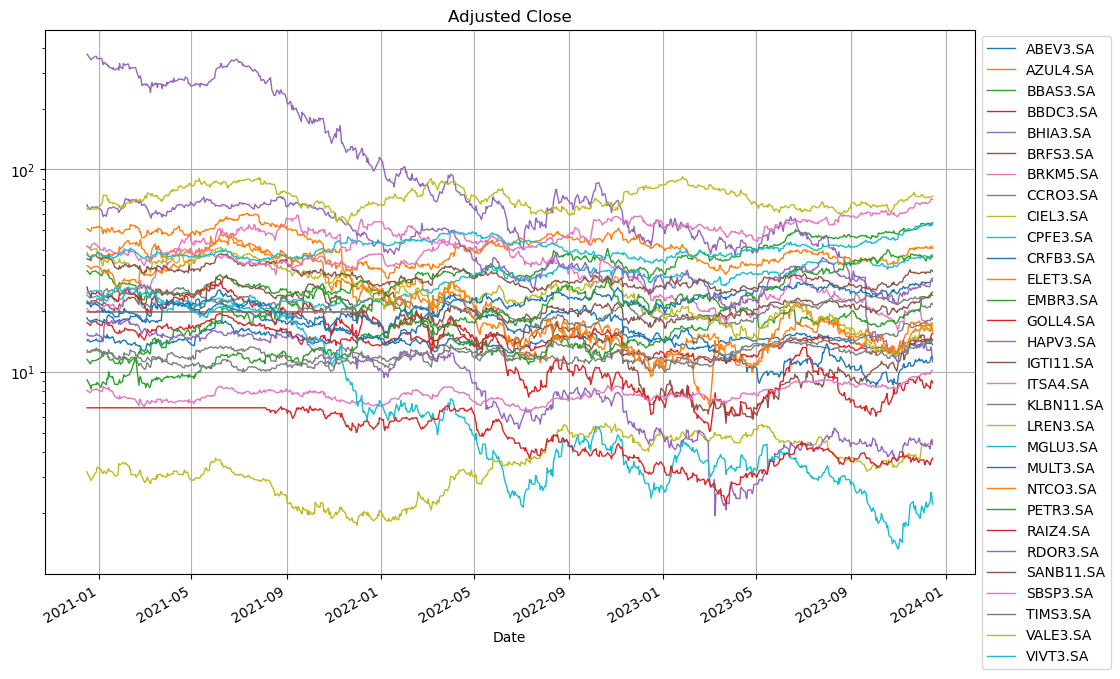

In [238]:
# number of years
n_years = 3.0

# historical period
end_date = datetime.datetime.today().date()
start_date = end_date - datetime.timedelta(round(n_years * 365))

assets = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]

assets.fillna(method="bfill", inplace=True)
assets.fillna(method="ffill", inplace=True)

assets.plot(logy=True, figsize=(12, 8), grid=True, lw=1, title="Adjusted Close")
plt.legend(bbox_to_anchor=(1.0, 1.0))

### Daily return and Mean Absolute Deviation of historical asset prices

#### Scaled asset prices

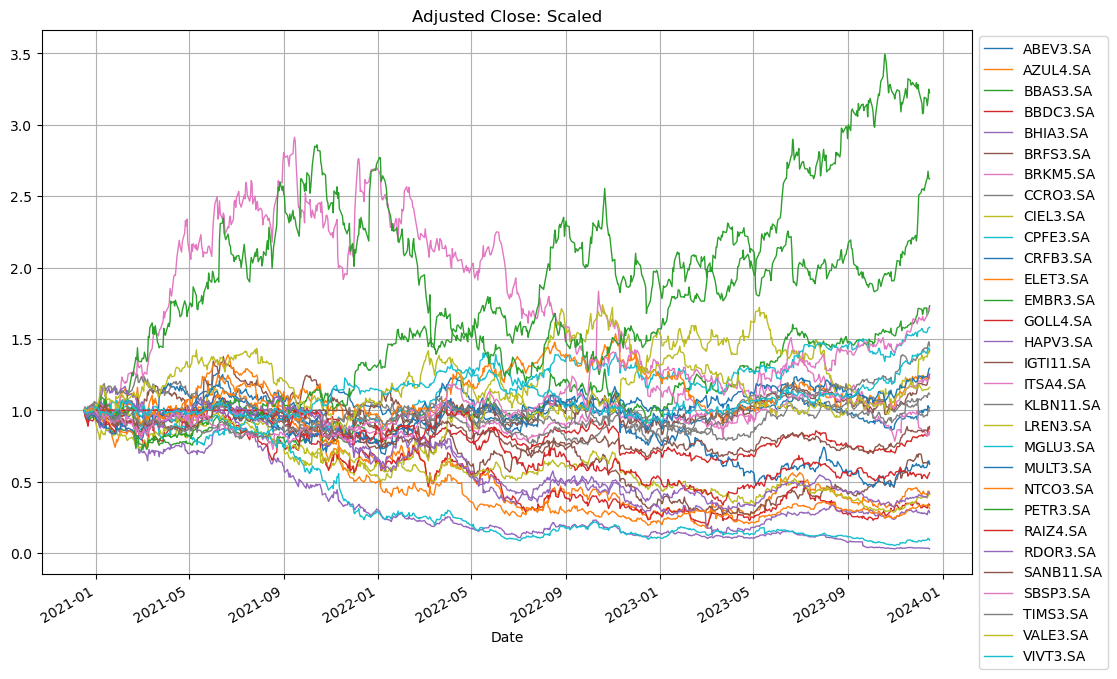

In [239]:
# scaled asset prices
assets_scaled = assets.div(assets.iloc[0])
assets_scaled.plot(figsize=(12, 8), grid=True, lw=1, title="Adjusted Close: Scaled")
plt.legend(bbox_to_anchor=(1.0, 1.0))

#### Statistics of daily returns

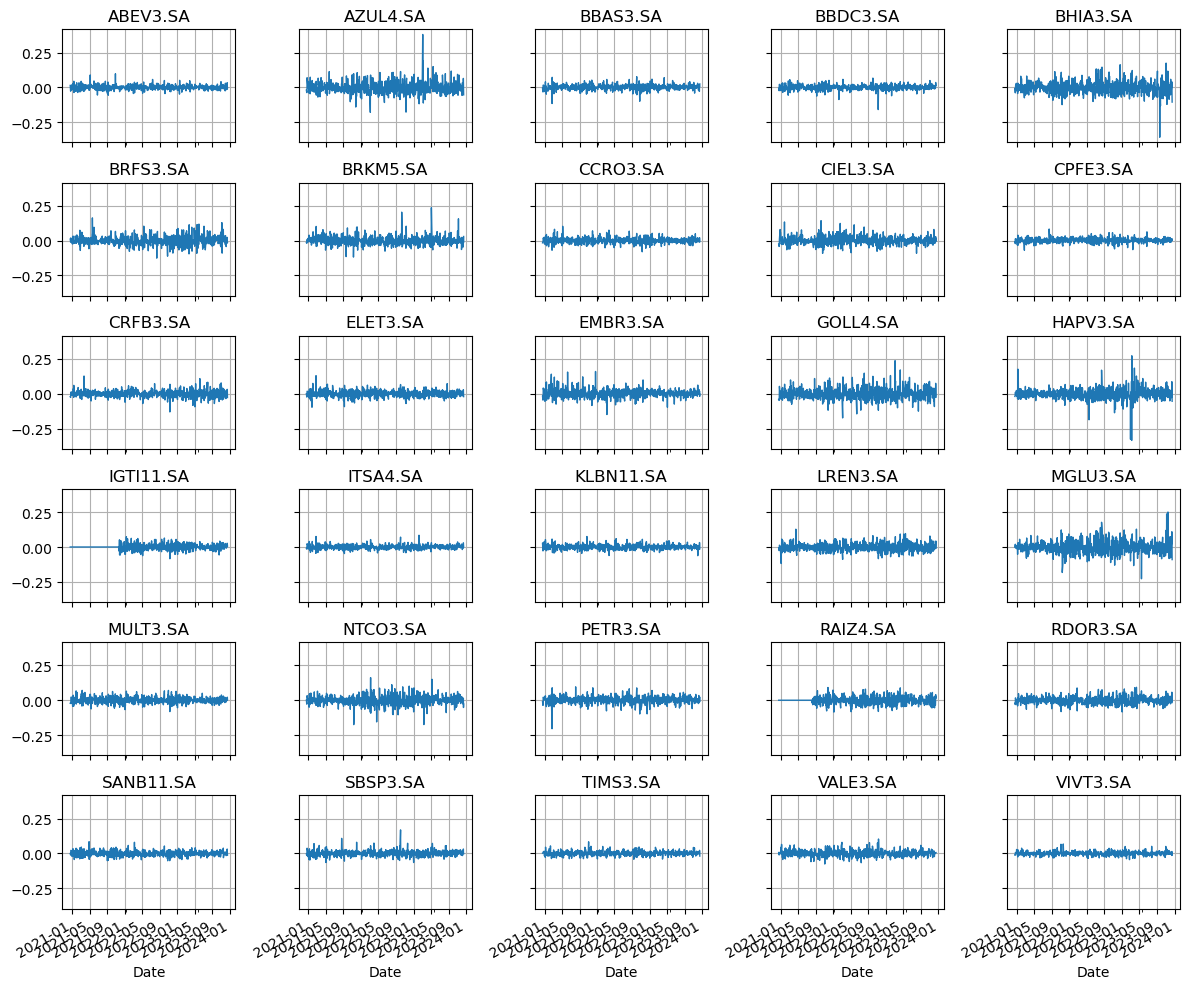

In [240]:
# daily returns
daily_returns = assets.diff()[1:] / assets.shift(1)[1:]

fig, ax = plt.subplots(6, 5, figsize=(12, 10), sharex=True, sharey=True)
for a, s in zip(ax.flatten(), sorted(daily_returns.columns)):
    daily_returns[s].plot(ax=a, lw=1, title=s, grid=True)

plt.tight_layout()

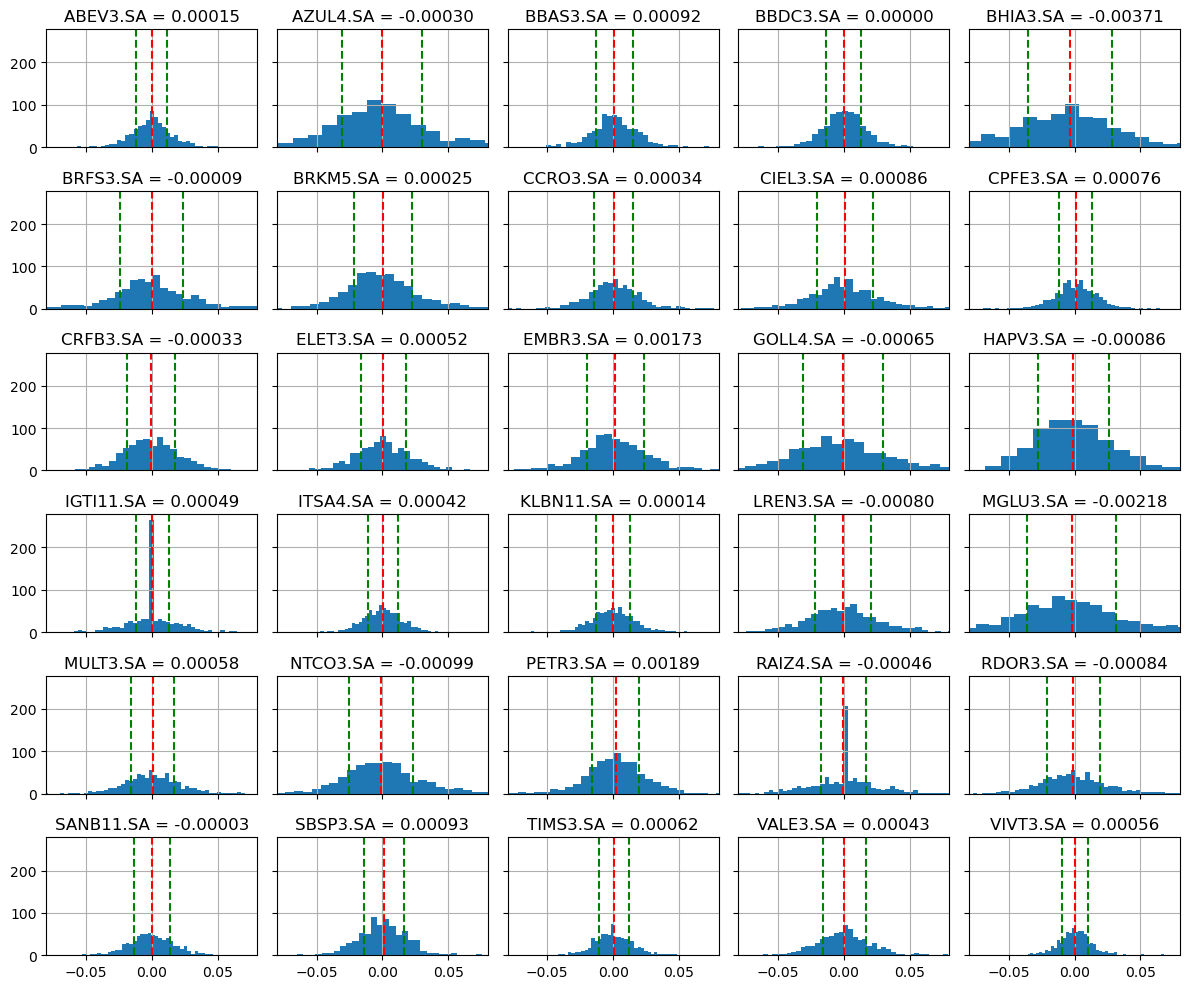

In [241]:
# distributions of returns
daily_returns = assets.diff()[1:] / assets.shift(1)[1:]

fig, ax = plt.subplots(6, 5, figsize=(12, 10), sharex=True, sharey=True)
ax = ax.flatten()

for a, s in zip(ax.flatten(), daily_returns.columns):
    daily_returns[s].hist(ax=a, lw=1, grid=True, bins=50)
    mean_return = daily_returns[s].mean()
    mean_absolute_deviation = abs((daily_returns[s] - mean_return)).mean()
    a.set_title(f"{s} = {mean_return:0.5f}")
    a.set_xlim(-0.08, 0.08)
    a.axvline(mean_return, color="r", linestyle="--")
    a.axvline(mean_return + mean_absolute_deviation, color="g", linestyle="--")
    a.axvline(mean_return - mean_absolute_deviation, color="g", linestyle="--")

plt.tight_layout()

#### Mean Absolute Deviation

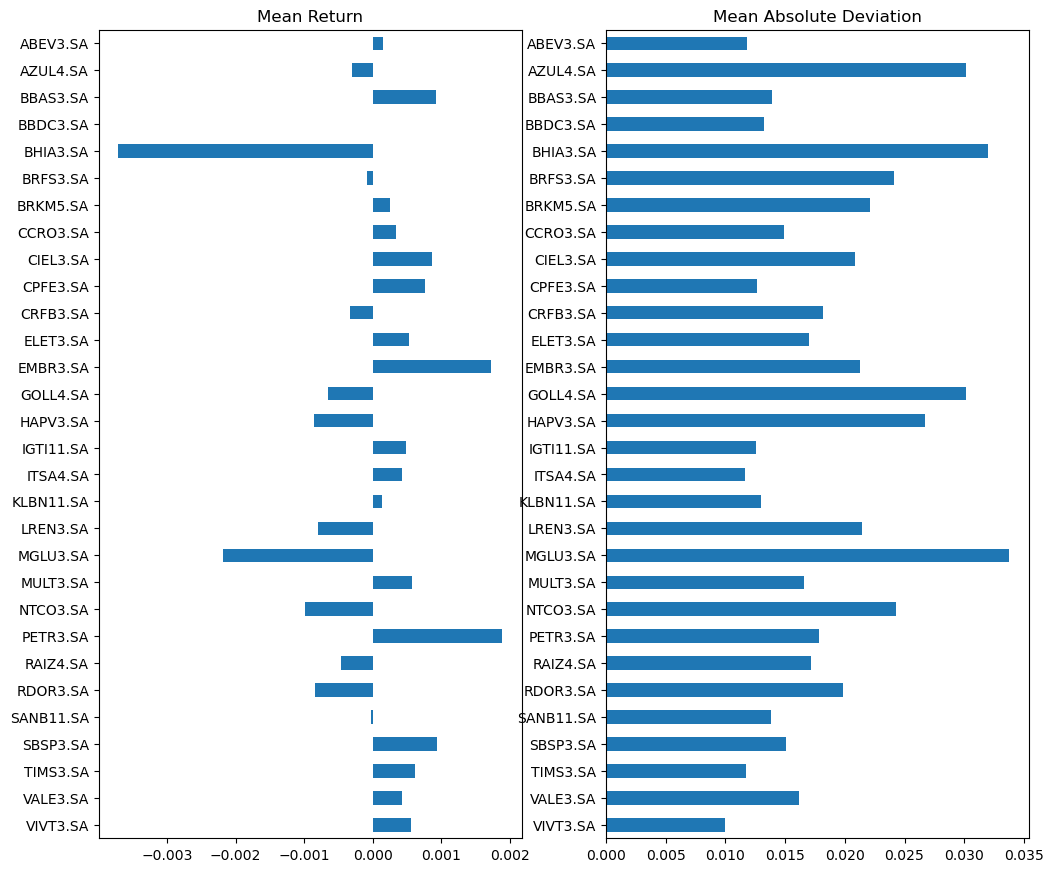

In [242]:
# bar charts of mean return and mean absolute deviation in returns

daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(1, 2, figsize=(12, 0.35 * len(daily_returns.columns)))
mean_return.plot(kind="barh", ax=ax[0], title="Mean Return")
ax[0].invert_yaxis()
mean_absolute_deviation.plot(kind="barh", ax=ax[1], title="Mean Absolute Deviation")
ax[1].invert_yaxis()

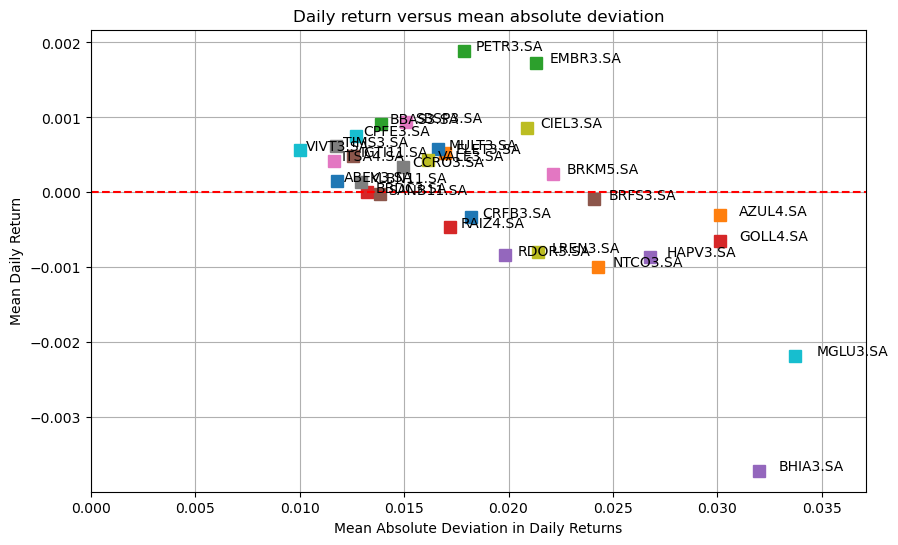

In [243]:
# plot return vs risk
daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], "s", ms=8)
    ax.text(mean_absolute_deviation[s] * 1.03, mean_return[s], s)

ax.set_xlim(0, 1.1 * mean_absolute_deviation.max())
ax.axhline(0, color="r", linestyle="--")
ax.set_title("Daily return versus mean absolute deviation")
ax.set_xlabel("Mean Absolute Deviation in Daily Returns")
ax.set_ylabel("Mean Daily Return")
ax.grid(True)

## Analysis of a portfolio of assets

### MAD portfolio optimization

#### AMPL model

In [244]:
%%writefile mad_portfolio.mod

param R default 0;
param w_lb default 0;
param w_ub default 1;

set ASSETS;
set TIME;

param daily_returns{TIME, ASSETS};
param mean_return{ASSETS};

var w{ASSETS};
var u{TIME} >= 0;
var v{TIME} >= 0;

minimize MAD: sum{t in TIME}(u[t] + v[t]) / card(TIME);

s.t. portfolio_returns {t in TIME}:
    u[t] - v[t] == sum{j in ASSETS}(w[j] * (daily_returns[t, j] - mean_return[j]));

s.t. sum_of_weights: sum{j in ASSETS} w[j] == 1;

s.t. mean_portfolio_return: sum{j in ASSETS}(w[j] * mean_return[j]) >= R;

s.t. no_short {j in ASSETS}: w[j] >= w_lb;

s.t. diversify {j in ASSETS}: w[j] <= w_ub;

Overwriting mad_portfolio.mod


HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.00860241961
857 simplex iterations
0 barrier iterations
 
Weight lower bound                0.000
Weight upper bound                0.200
Fraction of portfolio invested     1.000
Required portfolio daily return    0.00100
Portfolio mean daily return        0.00100
Portfolio mean absolute deviation  0.00860


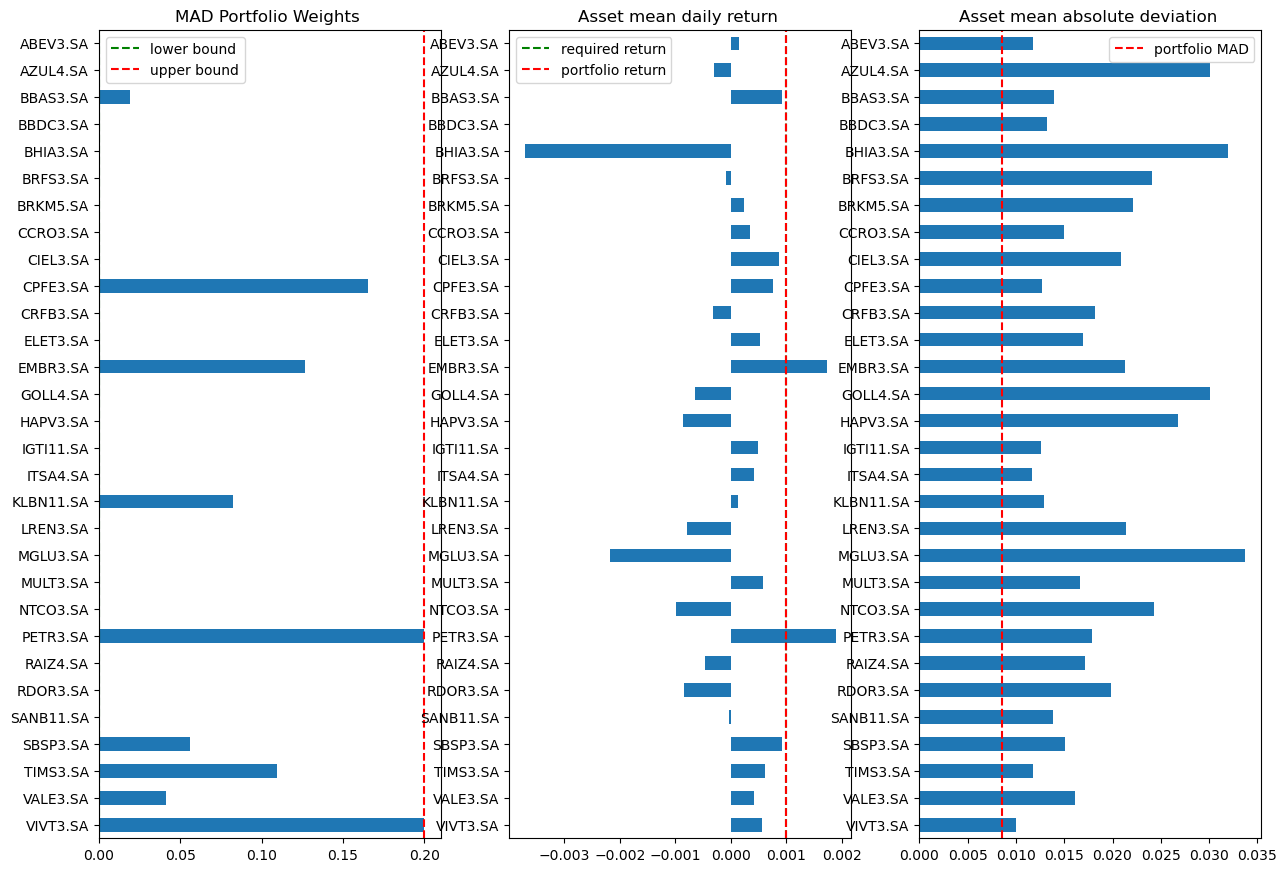

In [245]:
def mad_portfolio(assets, model_name="mad_portfolio.mod"):
    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
    mean_return = daily_returns.mean()

    daily_returns["Date"] = daily_returns.index.format()
    daily_returns.set_index("Date", inplace=True)

    ampl = AMPL()
    ampl.read(model_name)

    ampl.set["ASSETS"] = list(assets.columns)
    ampl.set["TIME"] = daily_returns.index.values

    ampl.param["daily_returns"] = daily_returns
    ampl.param["mean_return"] = mean_return

    return ampl


def mad_visualization(assets, m, constraint=""):
    mean_portfolio_return = m.get_value("sum{j in ASSETS}(w[j] * mean_return[j])")

    print(f"Weight lower bound                {m.param['w_lb'].value():0.3f}")
    print(f"Weight upper bound                {m.param['w_ub'].value():0.3f}")
    print(
        f"Fraction of portfolio invested     {m.get_value('sum{j in ASSETS} w[j]'):0.3f}"
    )
    print(f"Required portfolio daily return    {m.param['R'].value():0.5f}")
    print(f"Portfolio mean daily return        {mean_portfolio_return:0.5f}")
    print(f"Portfolio mean absolute deviation  {m.obj['MAD'].value():0.5f}")

    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
    mean_return = daily_returns.mean()
    mean_absolute_deviation = abs(daily_returns - mean_return).mean()
    mad_portfolio_weights = m.var["w"].to_pandas()

    fig, ax = plt.subplots(1, 3, figsize=(15, 0.35 * len(daily_returns.columns)))
    mad_portfolio_weights.plot(kind="barh", ax=ax[0], title=f"MAD Portfolio Weights {constraint}")
    ax[0].invert_yaxis()
    ax[0].axvline(m.param["w_lb"].value(), ls="--", color="g")
    ax[0].axvline(m.param["w_ub"].value(), ls="--", color="r")
    ax[0].legend(["lower bound", "upper bound"])

    mean_return.plot(kind="barh", ax=ax[1], title=f"Asset mean daily return {constraint}")
    ax[1].axvline(m.param["R"].value(), ls="--", color="g")

    ax[1].axvline(mean_portfolio_return, ls="--", color="r")
    ax[1].invert_yaxis()
    ax[1].legend(["required return", "portfolio return"])

    mean_absolute_deviation.plot(
        kind="barh", ax=ax[2], title=f"Asset mean absolute deviation {constraint}"
    )
    ax[2].axvline(m.obj["MAD"].value(), ls="--", color="r")
    ax[2].legend(["portfolio MAD"])
    ax[2].invert_yaxis()


m = mad_portfolio(assets)
m.param["w_lb"] = 0
m.param["w_ub"] = 0.2
m.param["R"] = 0.001
m.option["solver"] = SOLVER
m.solve()
mad_visualization(assets, m)

#### MAD risk versus return

HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
797 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007331985697
39 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007502938444
62 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007762436901
60 simplex iterations
0 barrier 

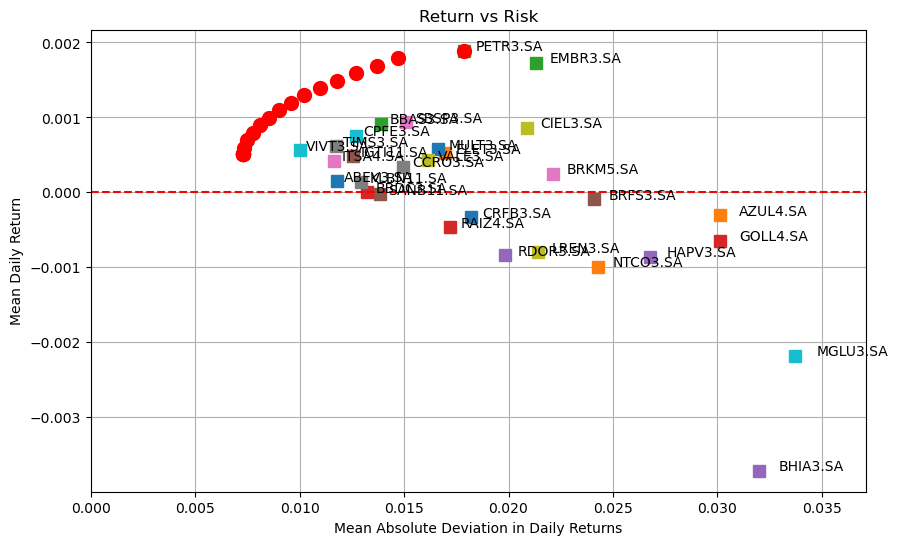

In [246]:
# plot return vs risk
daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], "s", ms=8)
    ax.text(mean_absolute_deviation[s] * 1.03, mean_return[s], s)

ax.set_xlim(0, 1.1 * max(mean_absolute_deviation))
ax.axhline(0, color="r", linestyle="--")
ax.set_title("Return vs Risk")
ax.set_xlabel("Mean Absolute Deviation in Daily Returns")
ax.set_ylabel("Mean Daily Return")
ax.grid(True)

m = mad_portfolio(assets)
for R in np.linspace(0, mean_return.max(), 20):
    m.param["R"] = R
    m.option["solver"] = SOLVER
    m.solve()
    mad_portfolio_weights = m.var["w"].to_pandas()
    portfolio_returns = daily_returns.dot(mad_portfolio_weights)
    portfolio_mean_return = portfolio_returns.mean()
    portfolio_mean_absolute_deviation = abs(
        portfolio_returns - portfolio_mean_return
    ).mean()
    ax.plot(portfolio_mean_absolute_deviation, portfolio_mean_return, "ro", ms=10)

#### Addition of a Risk-free Asset

In [247]:
%%writefile mad_portfolio_cash.mod

param R default 0;
param rf default 0;
param w_lb default 0;
param w_ub default 1;

set ASSETS;
set TIME;

param daily_returns{TIME, ASSETS};
param mean_return{ASSETS};

var w{ASSETS};
var u{TIME} >= 0;
var v{TIME} >= 0;

minimize MAD: sum{t in TIME}(u[t] + v[t]) / card(TIME);

s.t. portfolio_returns {t in TIME}:
    u[t] - v[t] == sum{j in ASSETS}(w[j] * (daily_returns[t, j] - mean_return[j]));

s.t. sum_of_weights: sum{j in ASSETS} w[j] <= 1;

s.t. mean_portfolio_return: sum{j in ASSETS}(w[j] * (mean_return[j] - rf)) >= R - rf;

s.t. no_short {j in ASSETS}: w[j] >= w_lb;

s.t. diversify {j in ASSETS}: w[j] <= w_ub;

Overwriting mad_portfolio_cash.mod


HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.008126105544
771 simplex iterations
0 barrier iterations
 
Weight lower bound                0.000
Weight upper bound                0.200
Fraction of portfolio invested     0.798
Required portfolio daily return    0.00100
Portfolio mean daily return        0.00100
Portfolio mean absolute deviation  0.00813


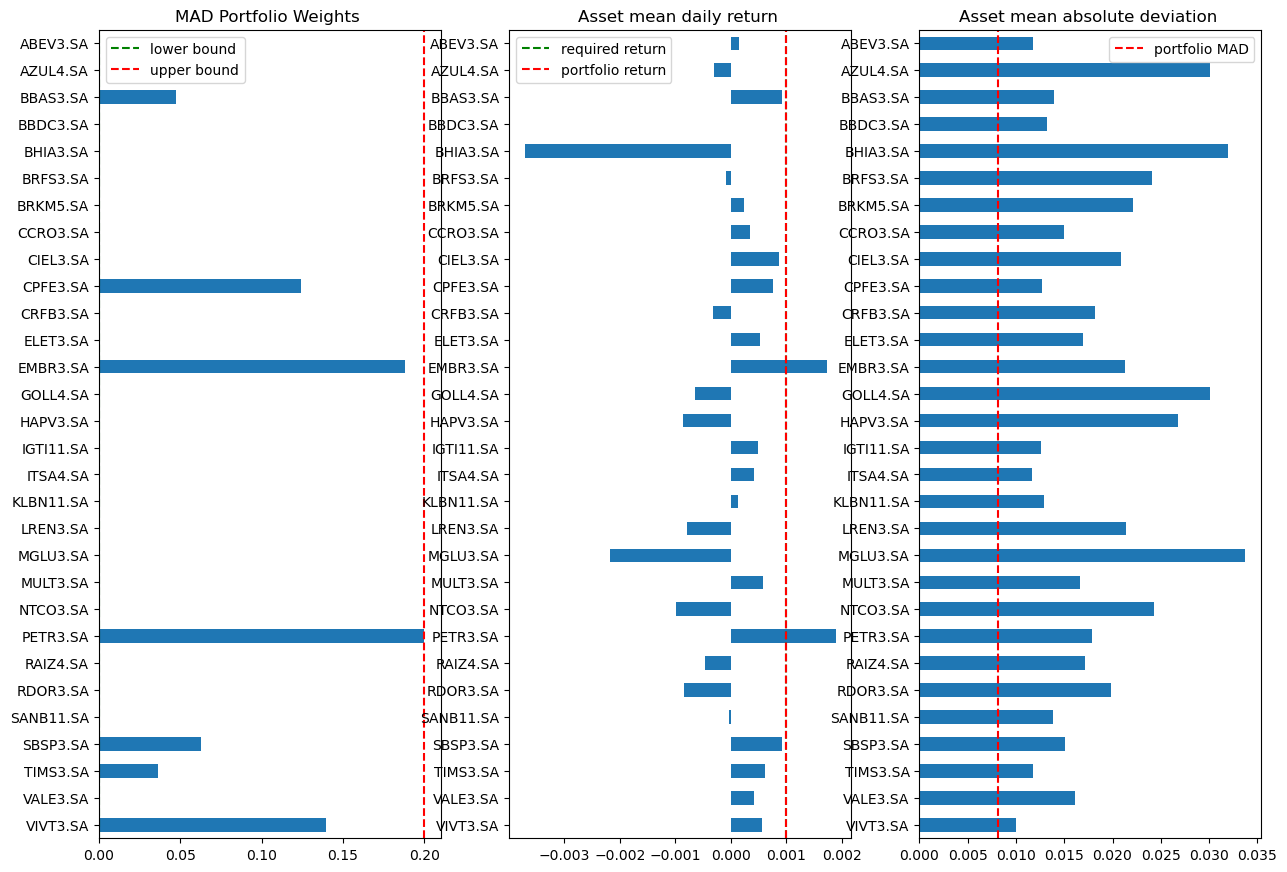

In [248]:
def mad_portfolio_cash(assets):
    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
    mean_return = daily_returns.mean()

    daily_returns["Date"] = daily_returns.index.format()
    daily_returns.set_index("Date", inplace=True)

    ampl = AMPL()
    ampl.read("mad_portfolio_cash.mod")

    ampl.set["ASSETS"] = list(assets.columns)
    ampl.set["TIME"] = daily_returns.index.values

    ampl.param["daily_returns"] = daily_returns
    ampl.param["mean_return"] = mean_return

    return ampl


m = mad_portfolio_cash(assets)
m.param["w_lb"] = 0
m.param["w_ub"] = 0.2
m.param["R"] = 0.001
m.option["solver"] = SOLVER
m.solve()
mad_visualization(assets, m)

#### MAD risk versus return with a risk-free asset

HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
797 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007331985697
39 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007502938444
62 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007762436901
60 simplex iterations
0 barrier 

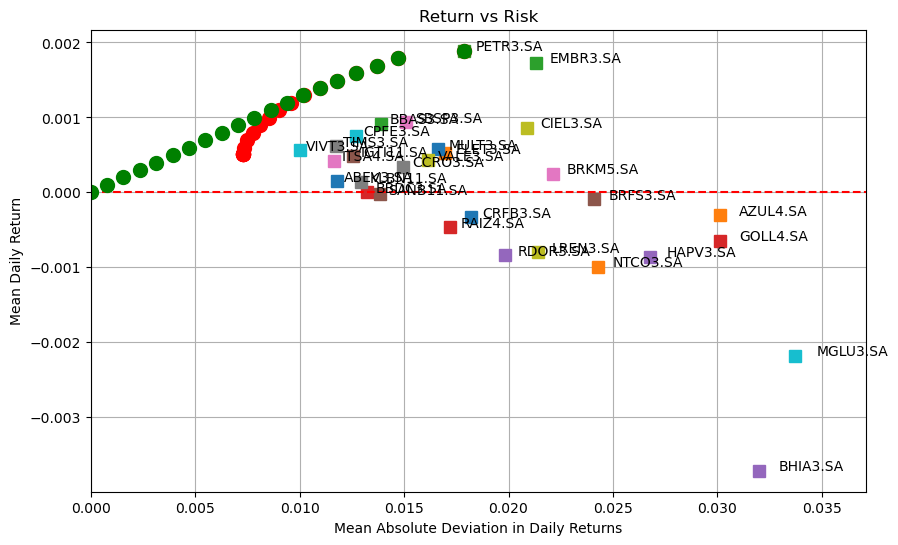

In [249]:
# plot return vs risk
daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
mean_return = daily_returns.mean()
mean_absolute_deviation = abs(daily_returns - mean_return).mean()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for s in assets.keys():
    ax.plot(mean_absolute_deviation[s], mean_return[s], "s", ms=8)
    ax.text(mean_absolute_deviation[s] * 1.03, mean_return[s], s)

ax.set_xlim(0, 1.1 * max(mean_absolute_deviation))
ax.axhline(0, color="r", linestyle="--")
ax.set_title("Return vs Risk")
ax.set_xlabel("Mean Absolute Deviation in Daily Returns")
ax.set_ylabel("Mean Daily Return")
ax.grid(True)

for color, m in zip(["ro", "go"], [mad_portfolio(assets), mad_portfolio_cash(assets)]):
    for R in np.linspace(0, mean_return.max(), 20):
        m.param["R"] = R
        m.option["solver"] = SOLVER
        m.solve()
        mad_portfolio_weights = m.var["w"].to_pandas()
        portfolio_returns = daily_returns.dot(mad_portfolio_weights)
        portfolio_mean_return = portfolio_returns.mean()
        portfolio_mean_absolute_deviation = abs(
            portfolio_returns - portfolio_mean_return
        ).mean()
        ax.plot(portfolio_mean_absolute_deviation, portfolio_mean_return, color, ms=10)

## Questão 1

Escolha 30 ações de empresas brasileiras e execute os códigos disponíveis para diferentes valores mínimos requeridos de retorno de portfolio e diferentes períodos de tempo. Reporte diferenças significativas, caso existam.

In [250]:
def mad_risk_vs_return(assets, constraint=""):

    # plot return vs risk
    daily_returns = assets.diff()[1:] / assets.shift(1)[1:]
    mean_return = daily_returns.mean()
    mean_absolute_deviation = abs(daily_returns - mean_return).mean()

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    for s in assets.keys():
        ax.plot(mean_absolute_deviation[s], mean_return[s], "s", ms=8)
        ax.text(mean_absolute_deviation[s] * 1.03, mean_return[s], s)

    ax.set_xlim(0, 1.1 * max(mean_absolute_deviation))
    ax.axhline(0, color="r", linestyle="--")
    ax.set_title(f"Return vs Risk {constraint}")
    ax.set_xlabel("Mean Absolute Deviation in Daily Returns")
    ax.set_ylabel("Mean Daily Return")
    ax.grid(True)

    m = mad_portfolio(assets)
    for R in np.linspace(0, mean_return.max(), 20):
        m.param["R"] = R
        m.option["solver"] = SOLVER
        m.solve()
        mad_portfolio_weights = m.var["w"].to_pandas()
        portfolio_returns = daily_returns.dot(mad_portfolio_weights)
        portfolio_mean_return = portfolio_returns.mean()
        portfolio_mean_absolute_deviation = abs(
            portfolio_returns - portfolio_mean_return
        ).mean()
        ax.plot(portfolio_mean_absolute_deviation, portfolio_mean_return, "ro", ms=10)

In [251]:
# group assets by year
assets_by_year = assets.groupby(assets.index.year).mean().tail(3).index.tolist()
assets_by_year

[2021, 2022, 2023]

In [252]:
# create a range of values for R
R_values = np.linspace(0.0001, 0.001, 5)
R_values

array([0.0001  , 0.000325, 0.00055 , 0.000775, 0.001   ])

------------------------------------------------------------
Y>=2021,R=0.0001
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007309318341
810 simplex iterations
0 barrier iterations
 
Weight lower bound                0.000
Weight upper bound                0.200
Fraction of portfolio invested     1.000
Required portfolio daily return    0.00010
Portfolio mean daily return        0.00050
Portfolio mean absolute deviation  0.00731
------------------------------------------------------------
Y>=2021,R=0.000325
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007309318341
823 simplex iterations
0 barrier iterations
 
Weight lower bound                0.000
Weight upper bound                0.200
Fraction of portfolio invested     1.000
Required portfolio daily return    0.00032
Portfolio mean daily return        0.00050
Portfolio mean absolute deviation  0.00731
------------------------------------------------------------
Y>=2021,R=0.00055
HiGHS 1.6.0:HiGHS 1.6.0: optimal so

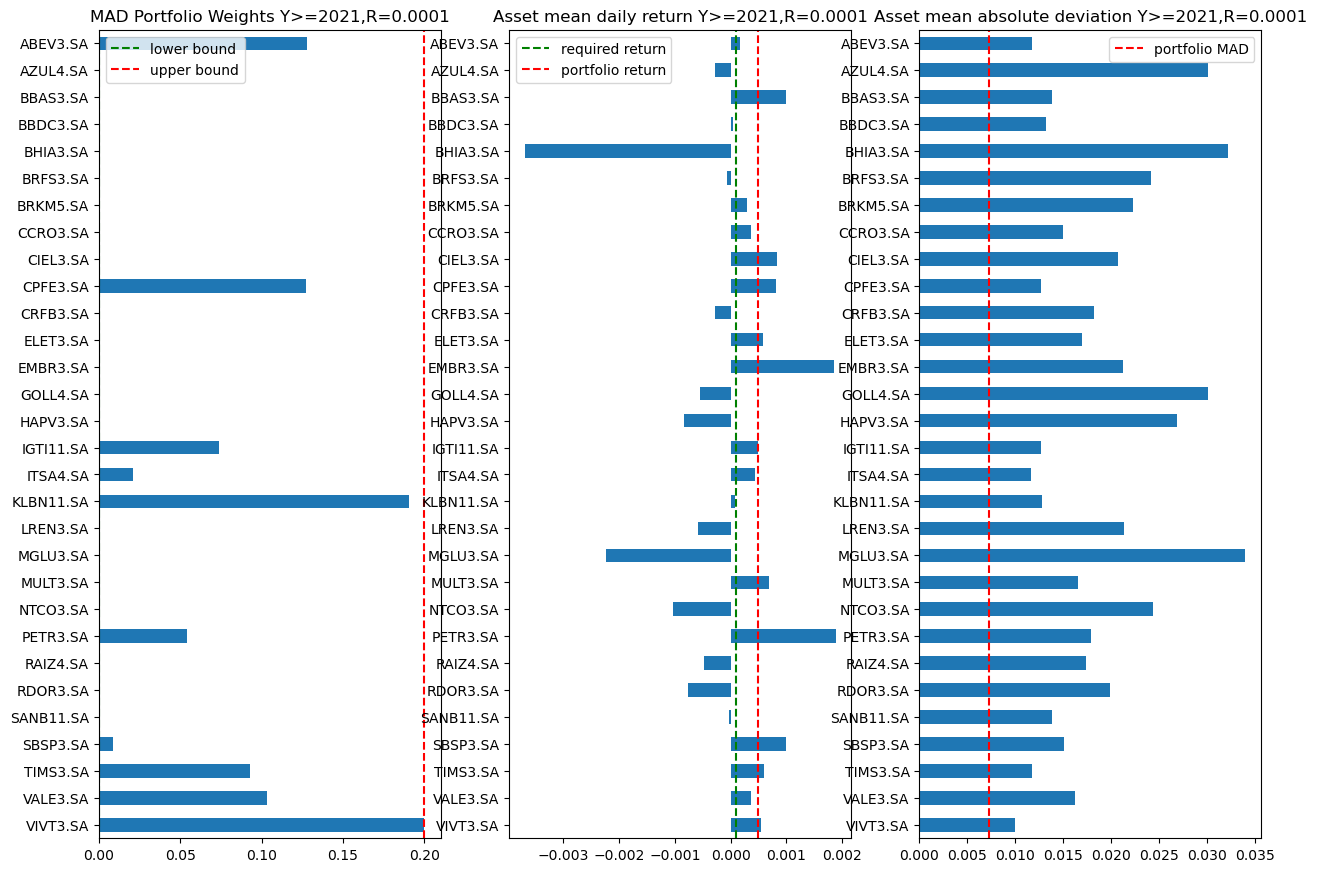

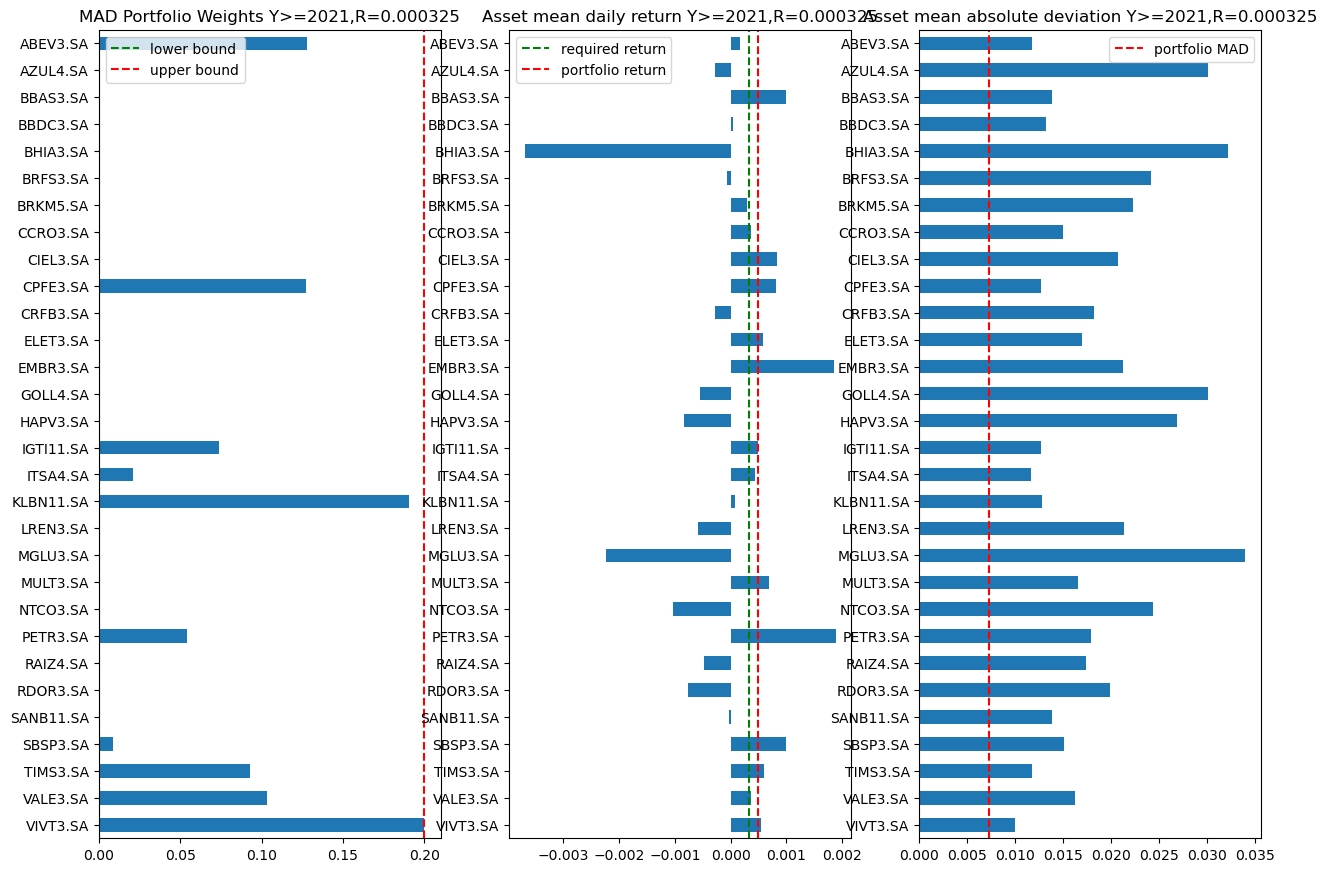

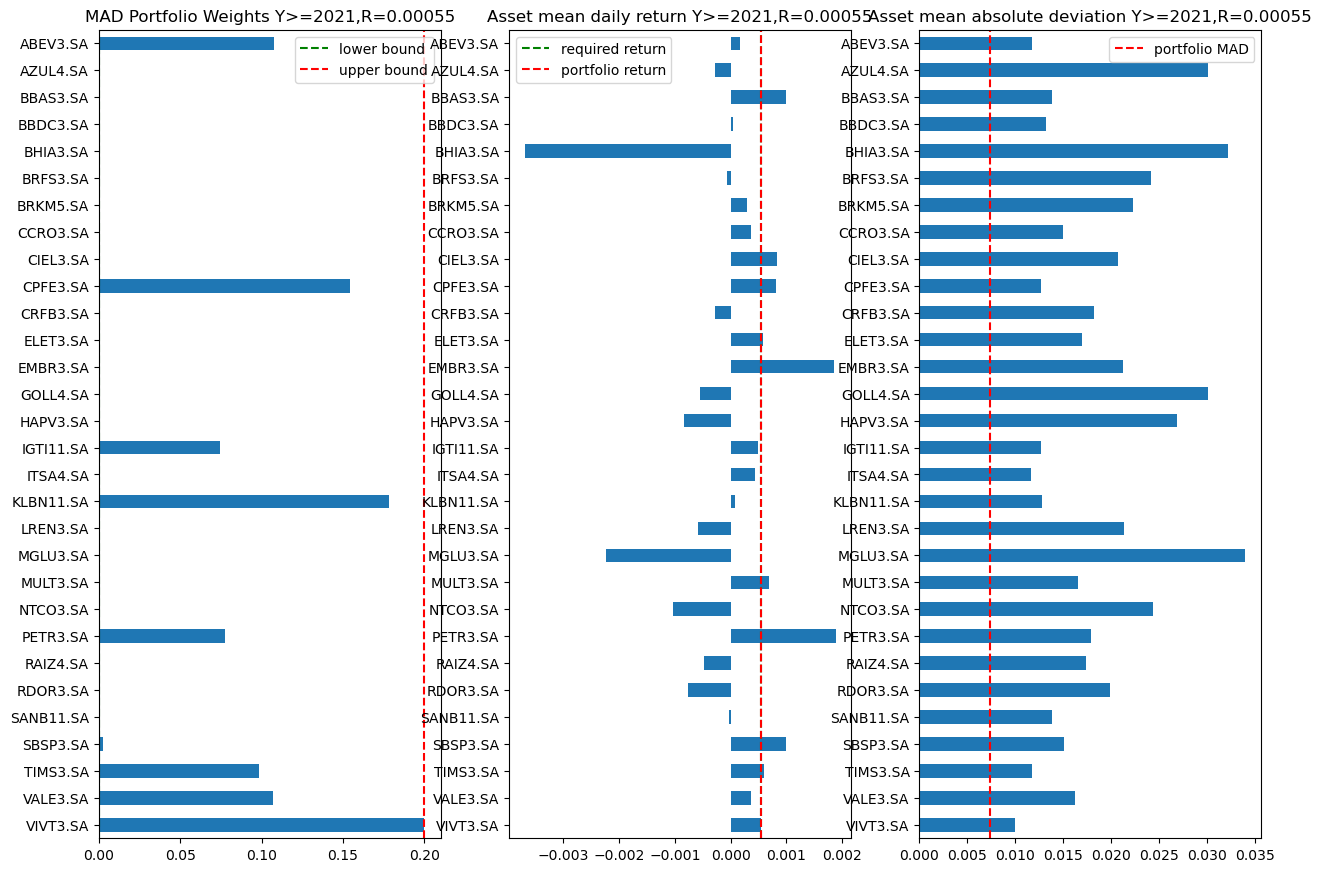

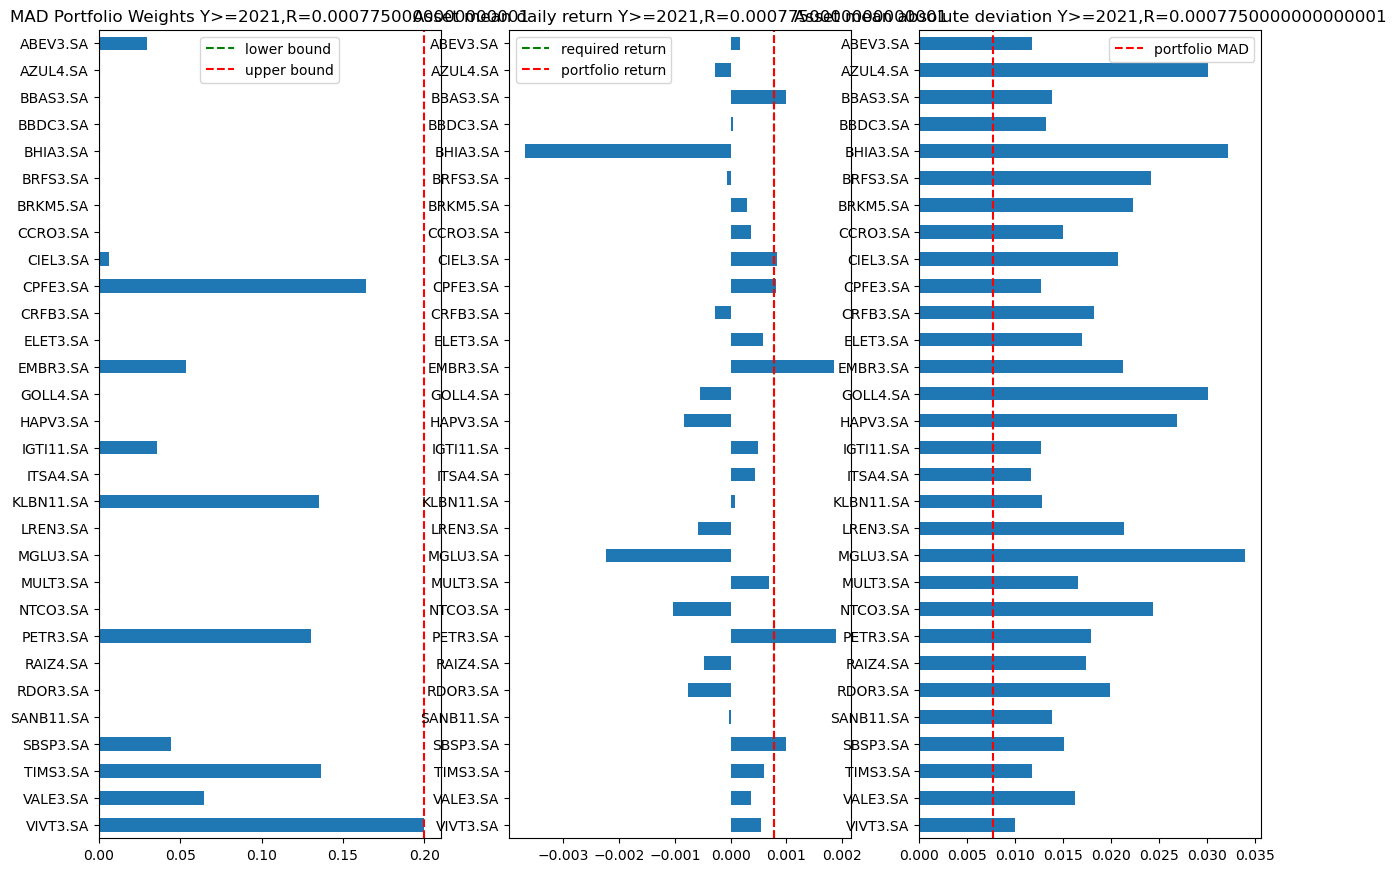

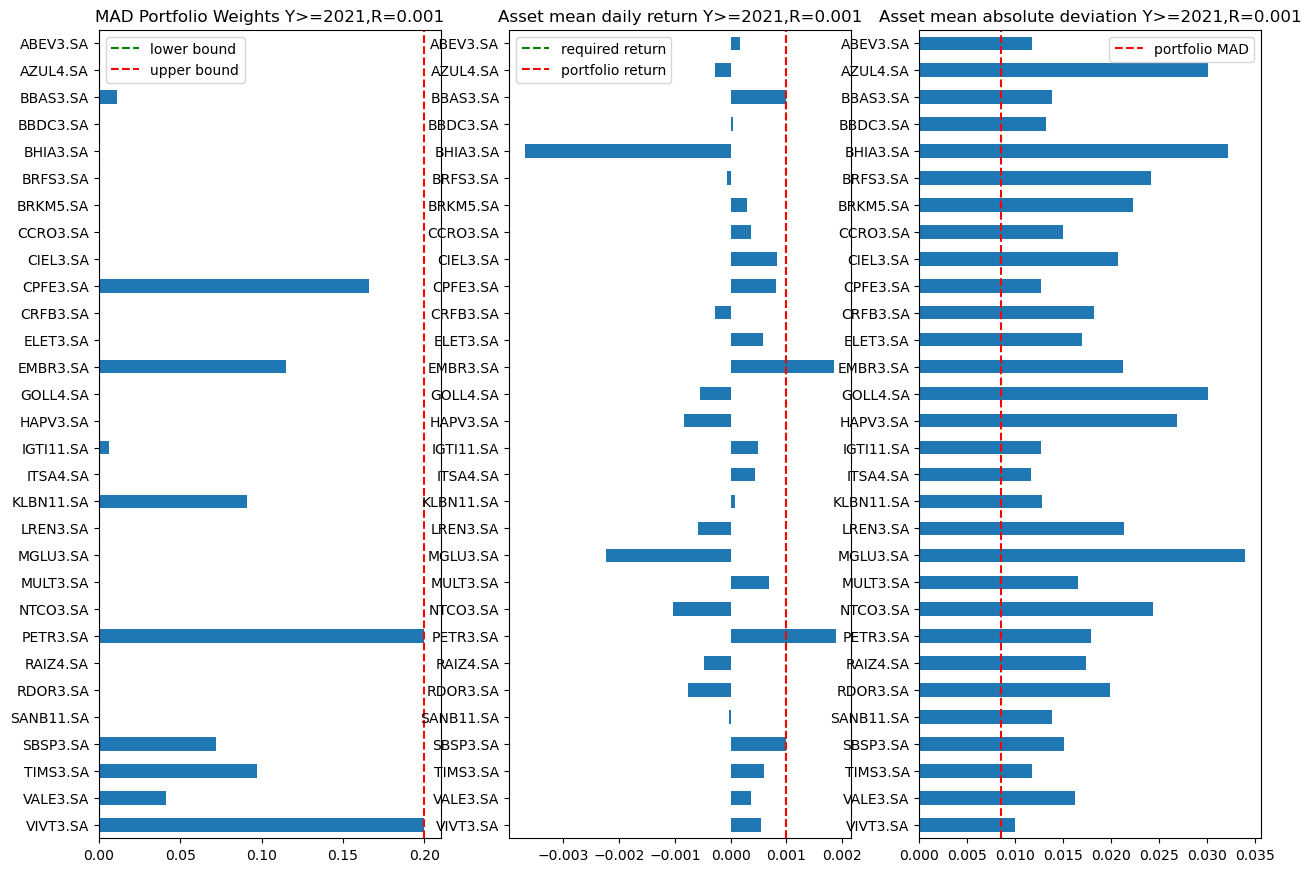

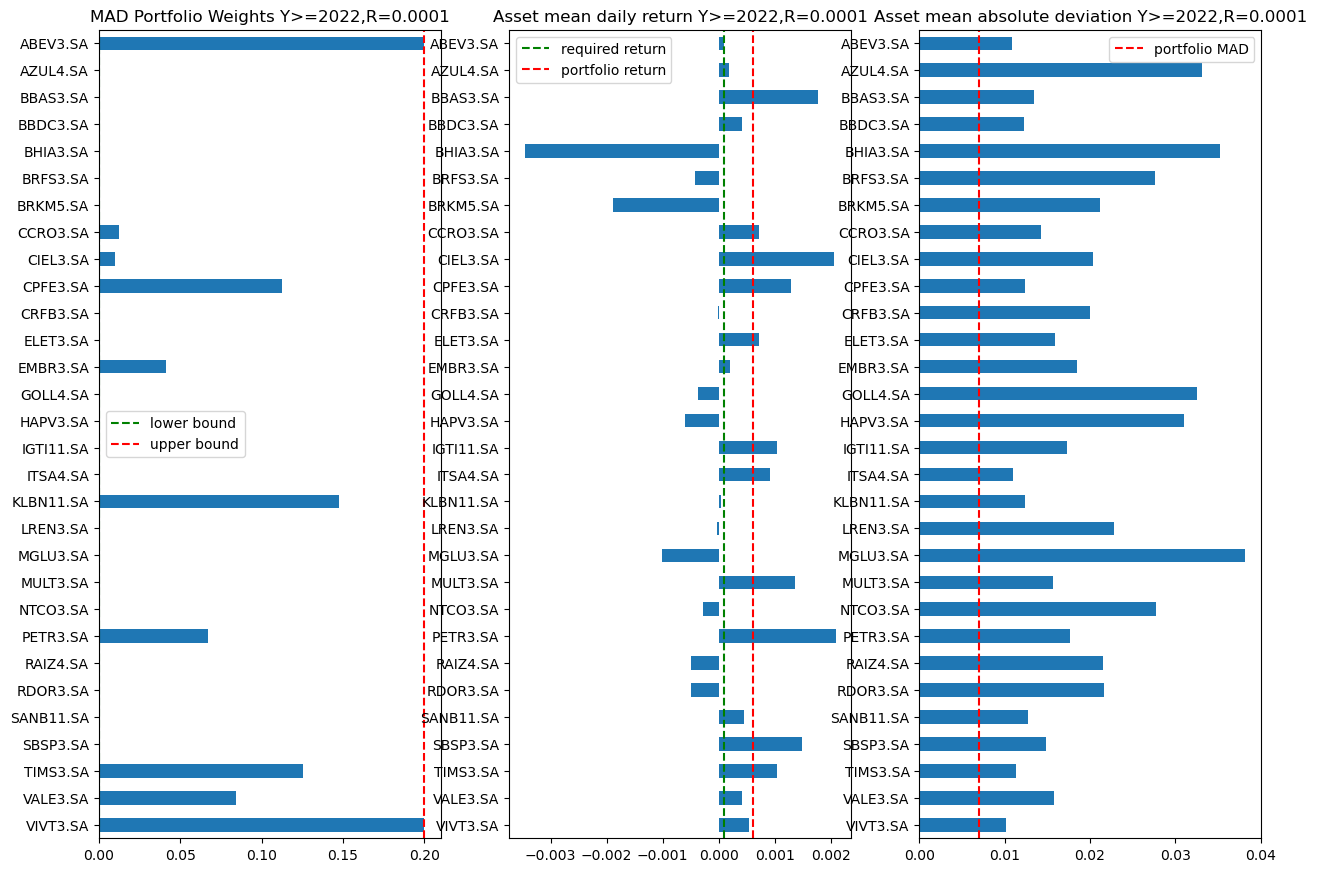

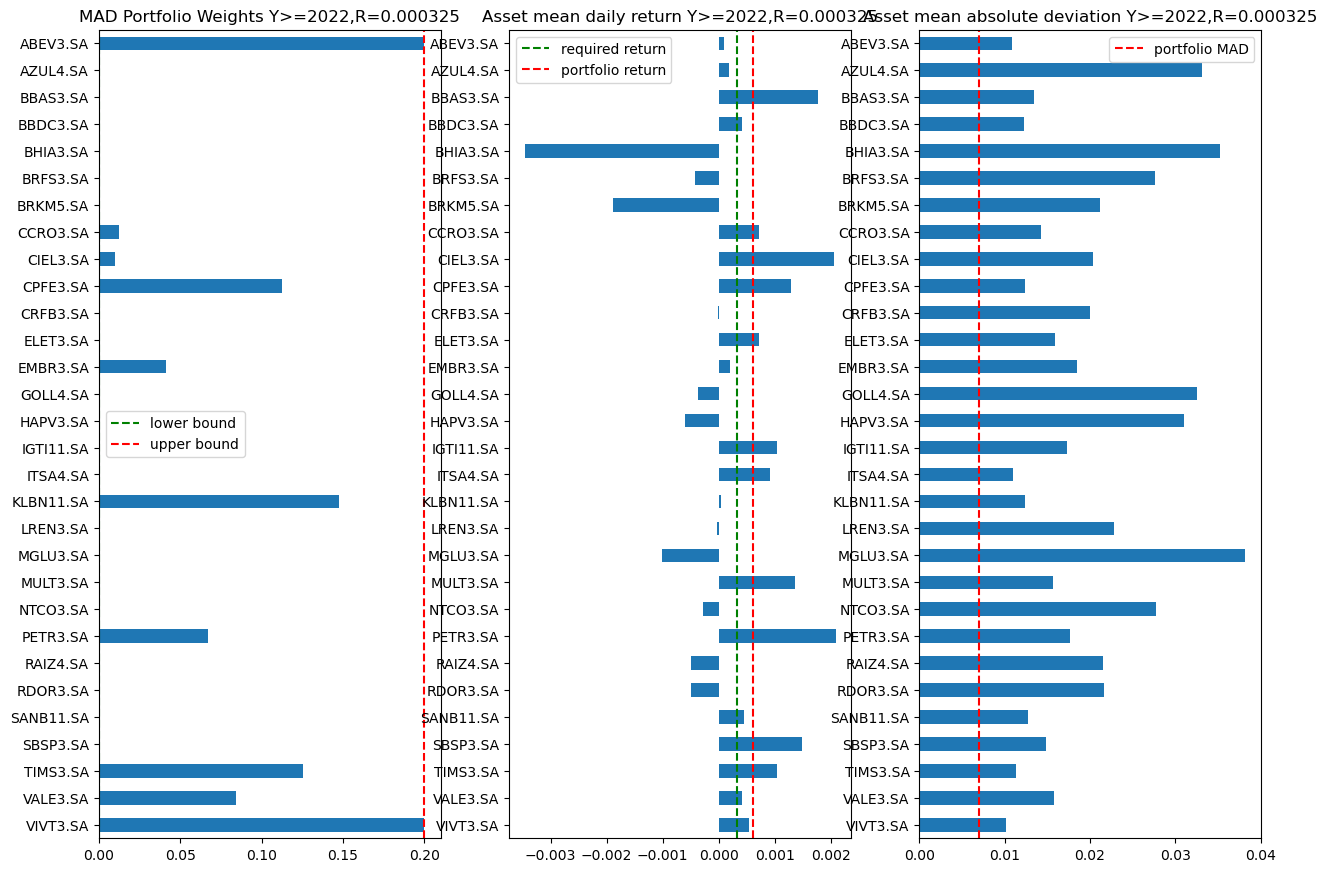

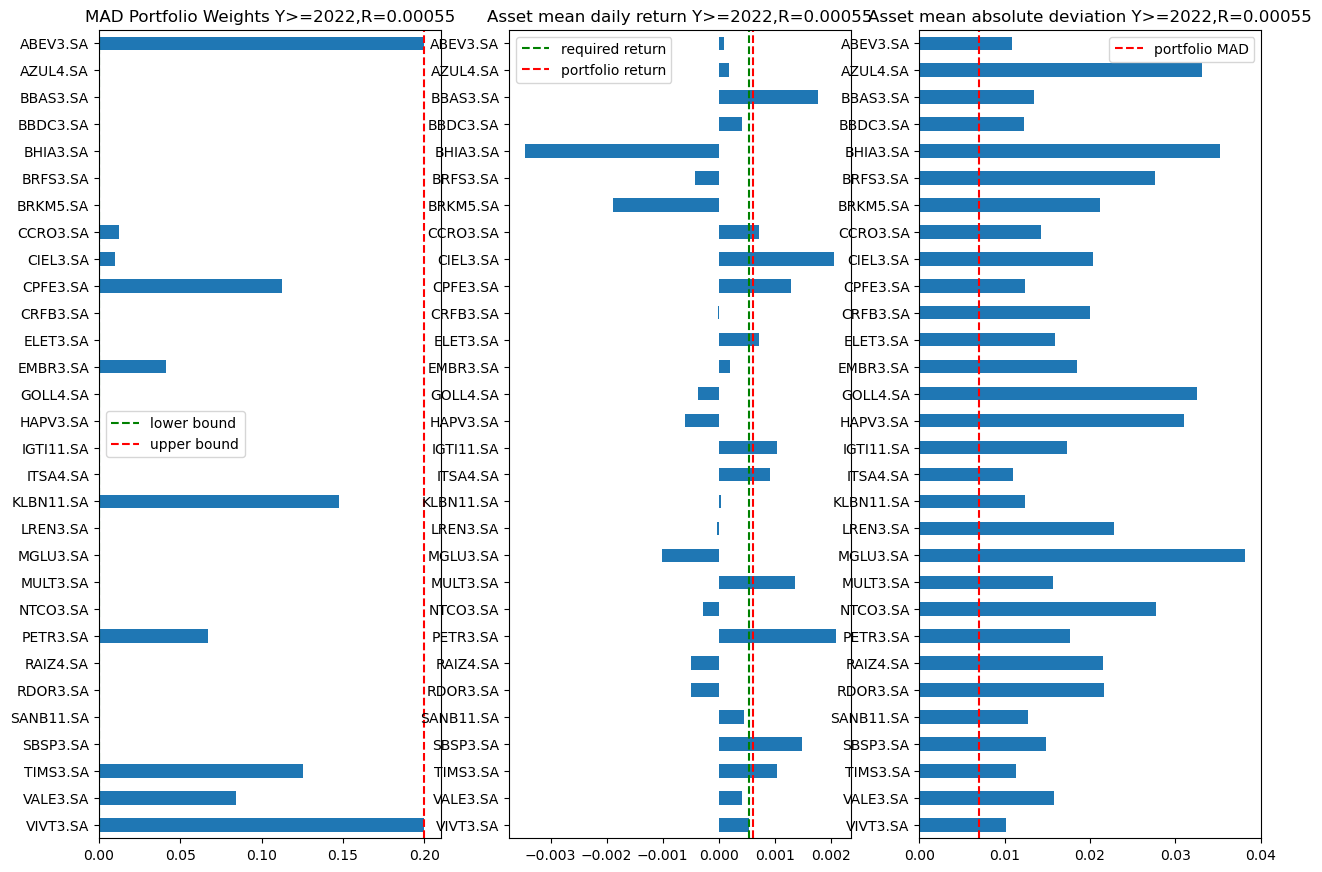

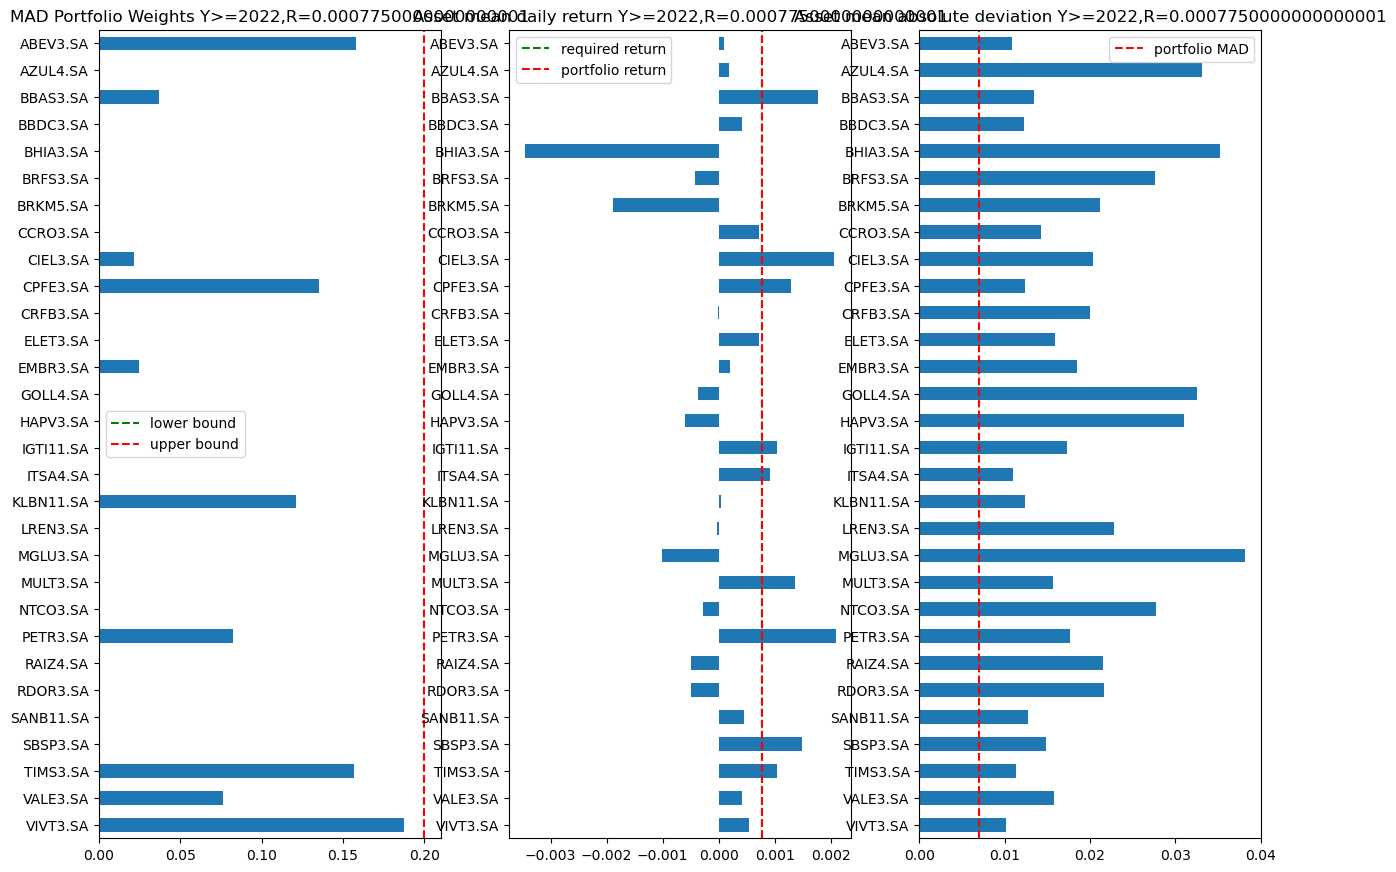

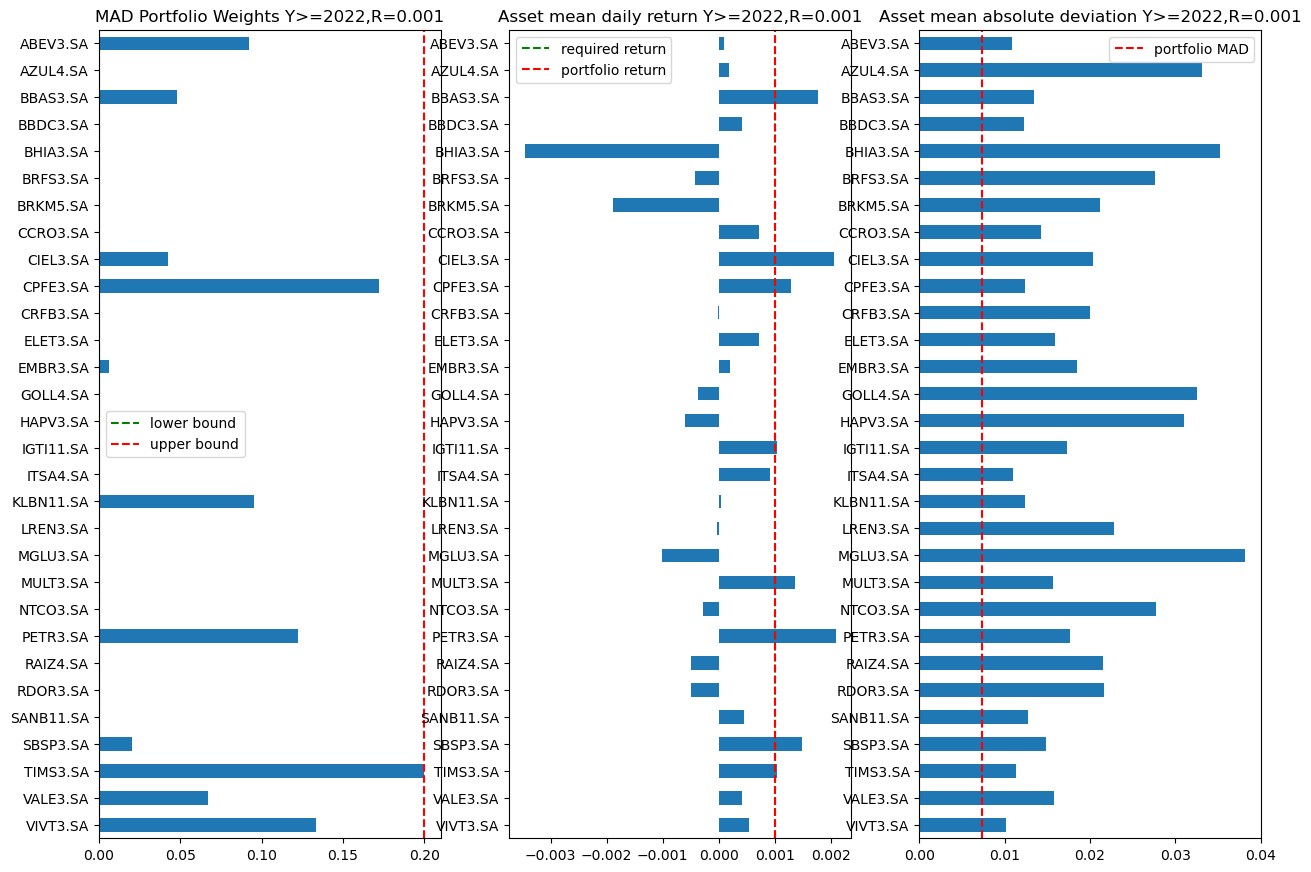

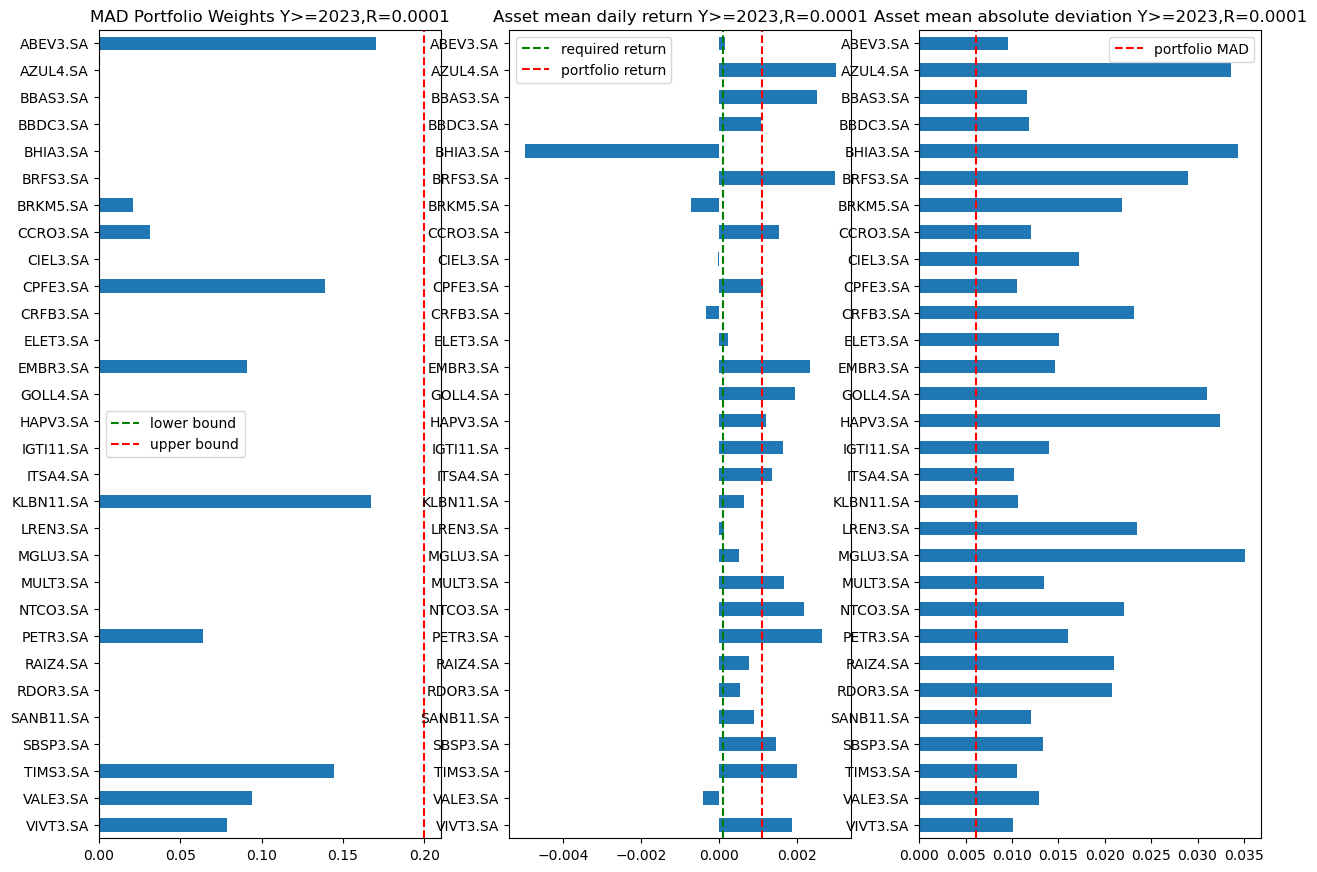

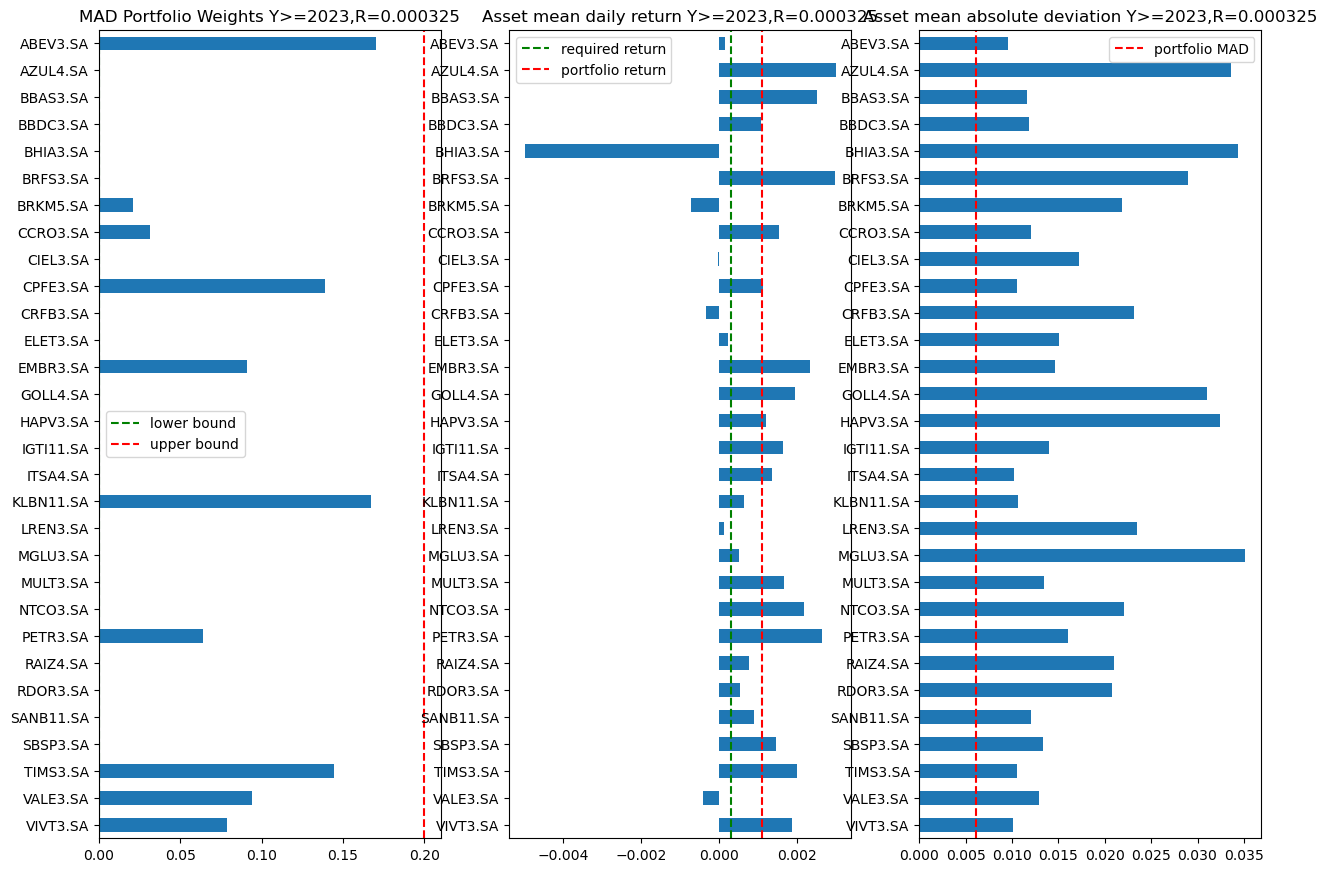

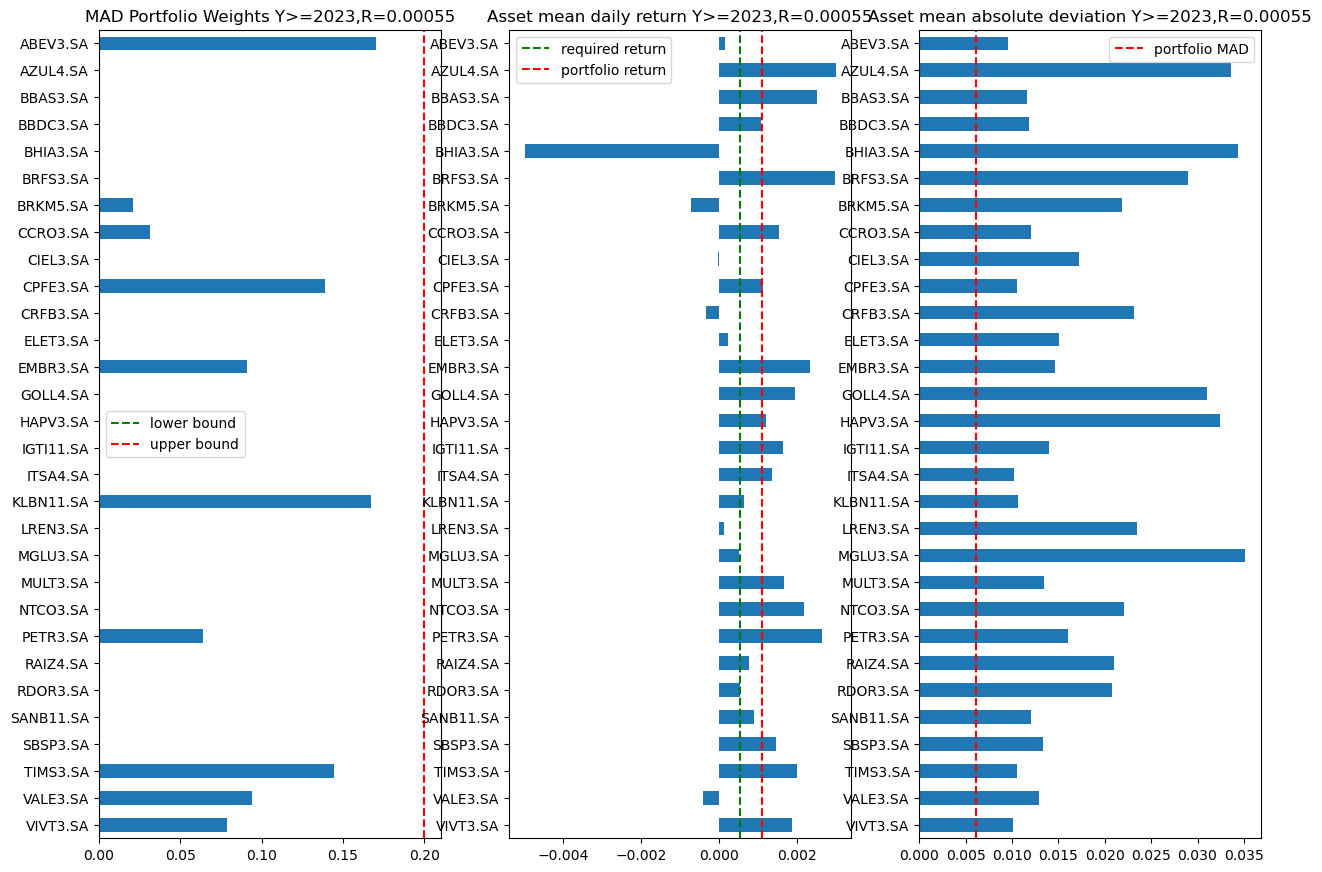

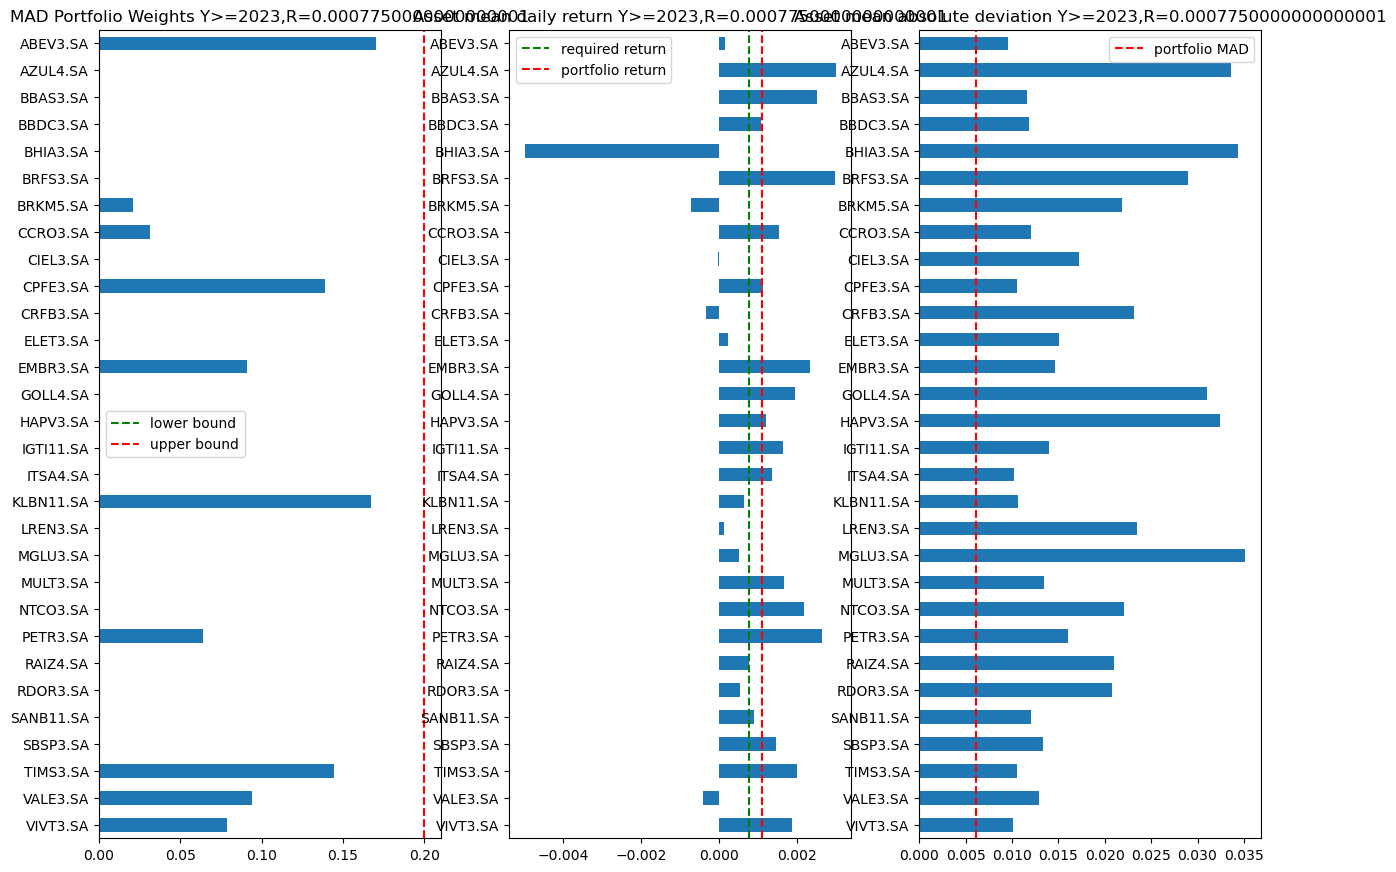

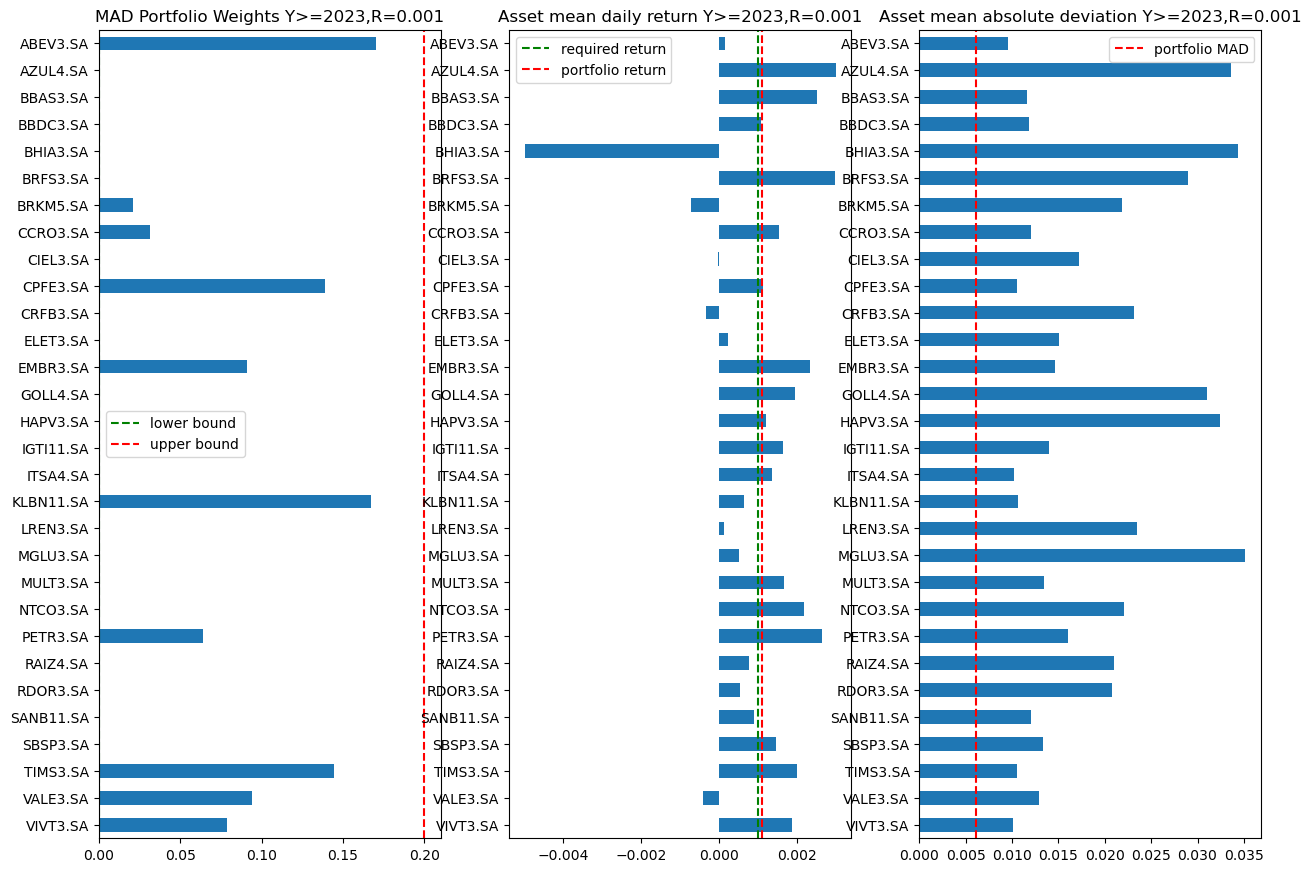

In [253]:
# for each year as a starting year in last 3 years, slice assets and get the MAD portfolio for each one
for year in assets_by_year:
    for R in R_values:
        print("-" * 60)
        constraint = f"Y>={year},R={R}"
        print(constraint)
        assets_year = assets[assets.index.year >= year]
        m = mad_portfolio(assets_year)
        m.param["w_lb"] = 0
        m.param["w_ub"] = 0.2
        m.param["R"] = R
        m.option["solver"] = SOLVER
        m.solve()
        mad_visualization(assets_year, m, constraint=constraint)

------------------------------------------------------------
Year >= 2021
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
797 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007284238545
0 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007331985697
39 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.007502938444
62 simplex iterations
0 barrier iterations
 
HiGHS 1.6.0:HiGHS 1.6.0: o

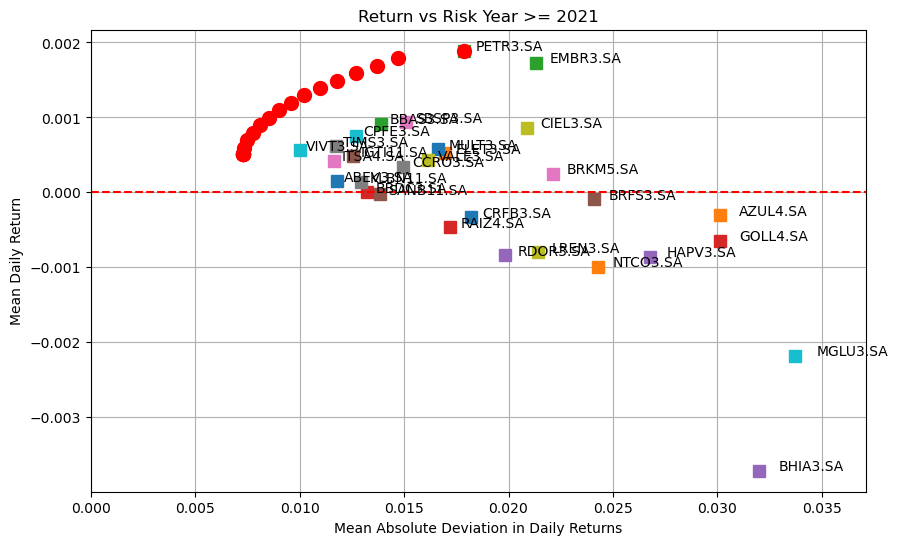

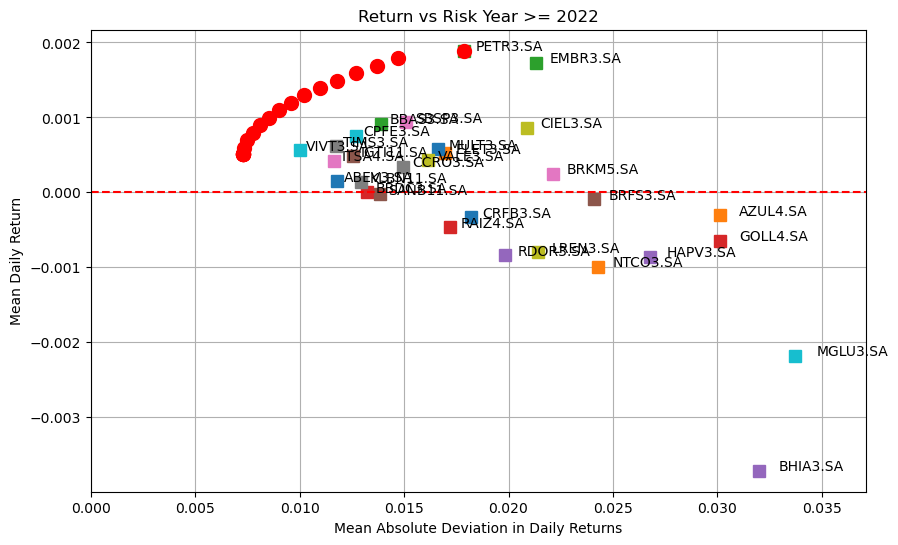

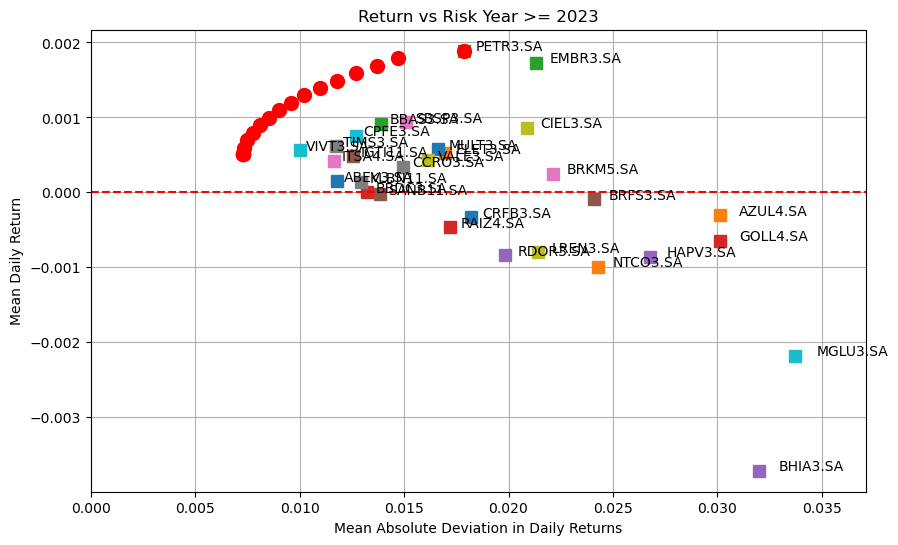

In [254]:
# for each year as a starting year in last 3 years, slice assets and get the MAD portfolio for each one
for year in assets_by_year:
    print("-" * 60)
    constraint = f"Year >= {year}"
    print(constraint)
    assets_year = assets[assets.index.year >= year]
    mad_risk_vs_return(assets, constraint=constraint)

## Questão 2

Para os cenários acima (escolhidos por você), varie os limitantes superiores que induzem diversificação; uma das variantes não deve ter condições de diversificação nenhuma. Reporte diferenças significativas, caso existam.

In [255]:
# get the last assets_by_year
assets_year = assets[assets.index.year >= assets_by_year[-1]]

In [256]:
# create a range of values for w_ub
w_ub_values = np.linspace(0, 5, 5)
w_ub_values

array([0.  , 1.25, 2.5 , 3.75, 5.  ])

------------------------------------------------------------
Y>=2023,w_ub=0.0
	presolve, variable w['ABEV3.SA']:
		impossible deduced bounds: lower = 5.91359, upper = 0
	presolve, variable w['ABEV3.SA']:
		impossible deduced bounds: lower = 1, upper = 0
	
	Please report any bugs at: https://github.com/ampl/amplpy
	
	For support/feedback go to https://discuss.ampl.com or e-mail <support@ampl.com>
	
Weight lower bound                0.000
Weight upper bound                0.000
Fraction of portfolio invested     0.000
Required portfolio daily return    0.00100
Portfolio mean daily return        0.00000
Portfolio mean absolute deviation  0.00000
------------------------------------------------------------
Y>=2023,w_ub=1.25
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.006055398747
298 simplex iterations
0 barrier iterations
 
Weight lower bound                0.000
Weight upper bound                1.250
Fraction of portfolio invested     1.000
Required portfolio daily return    

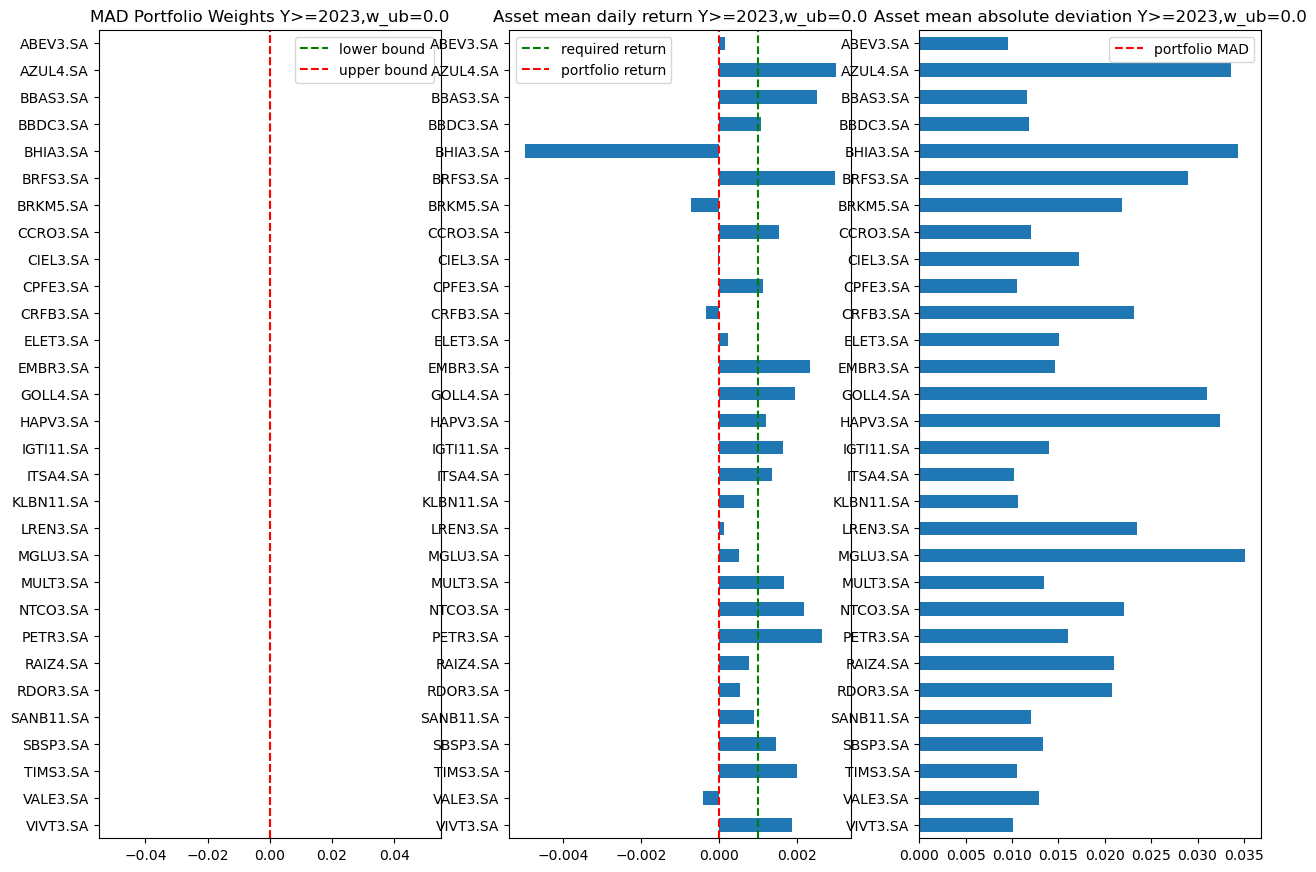

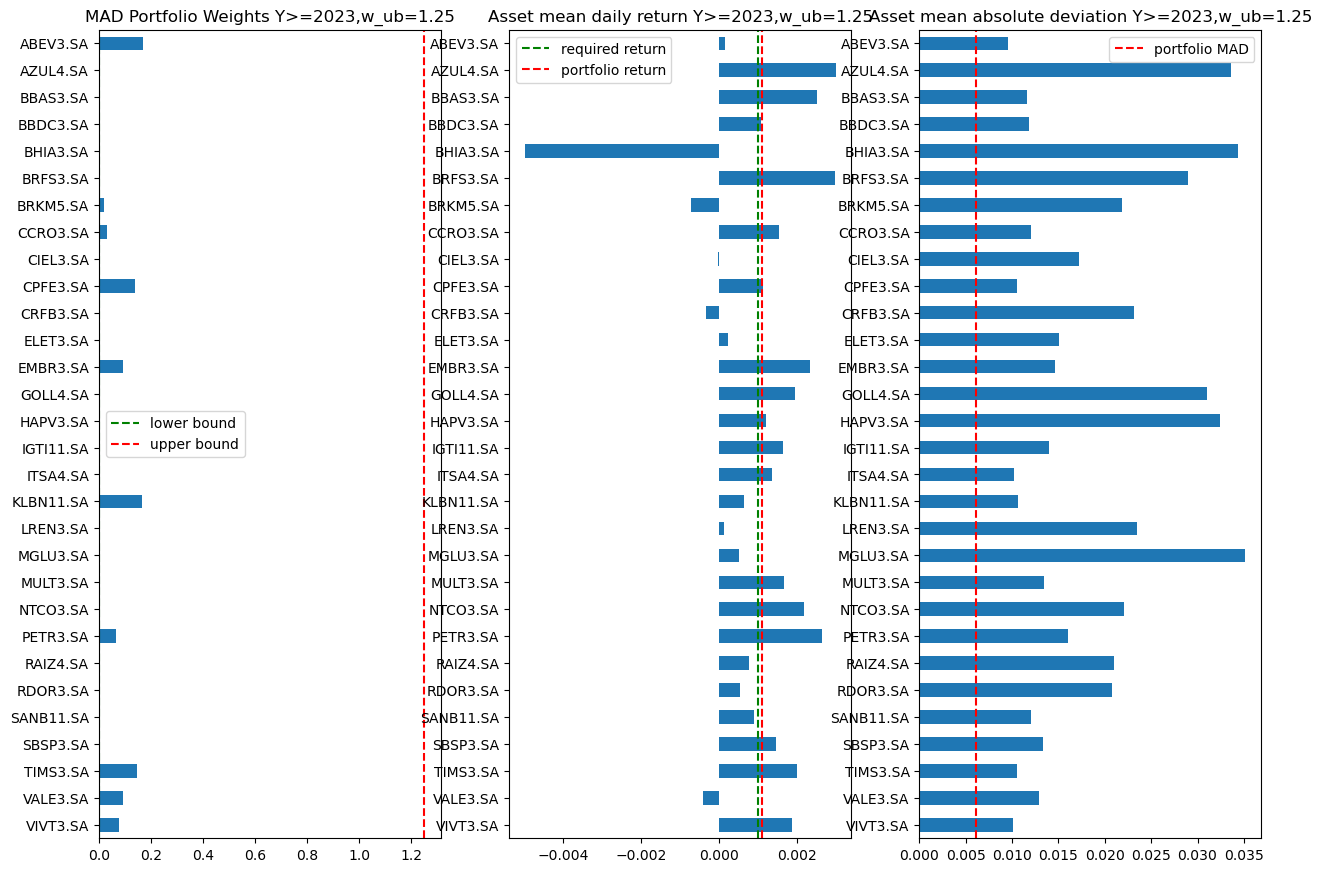

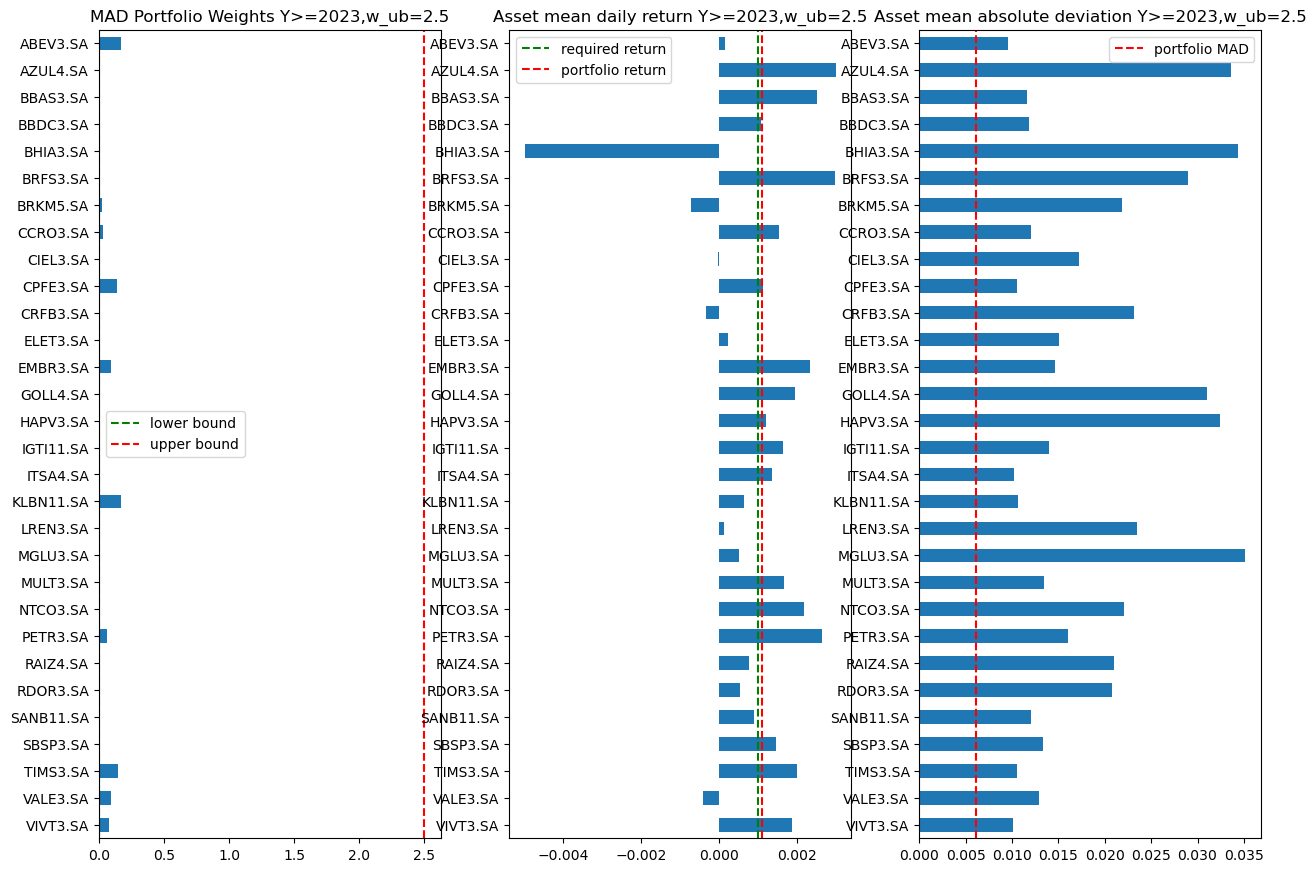

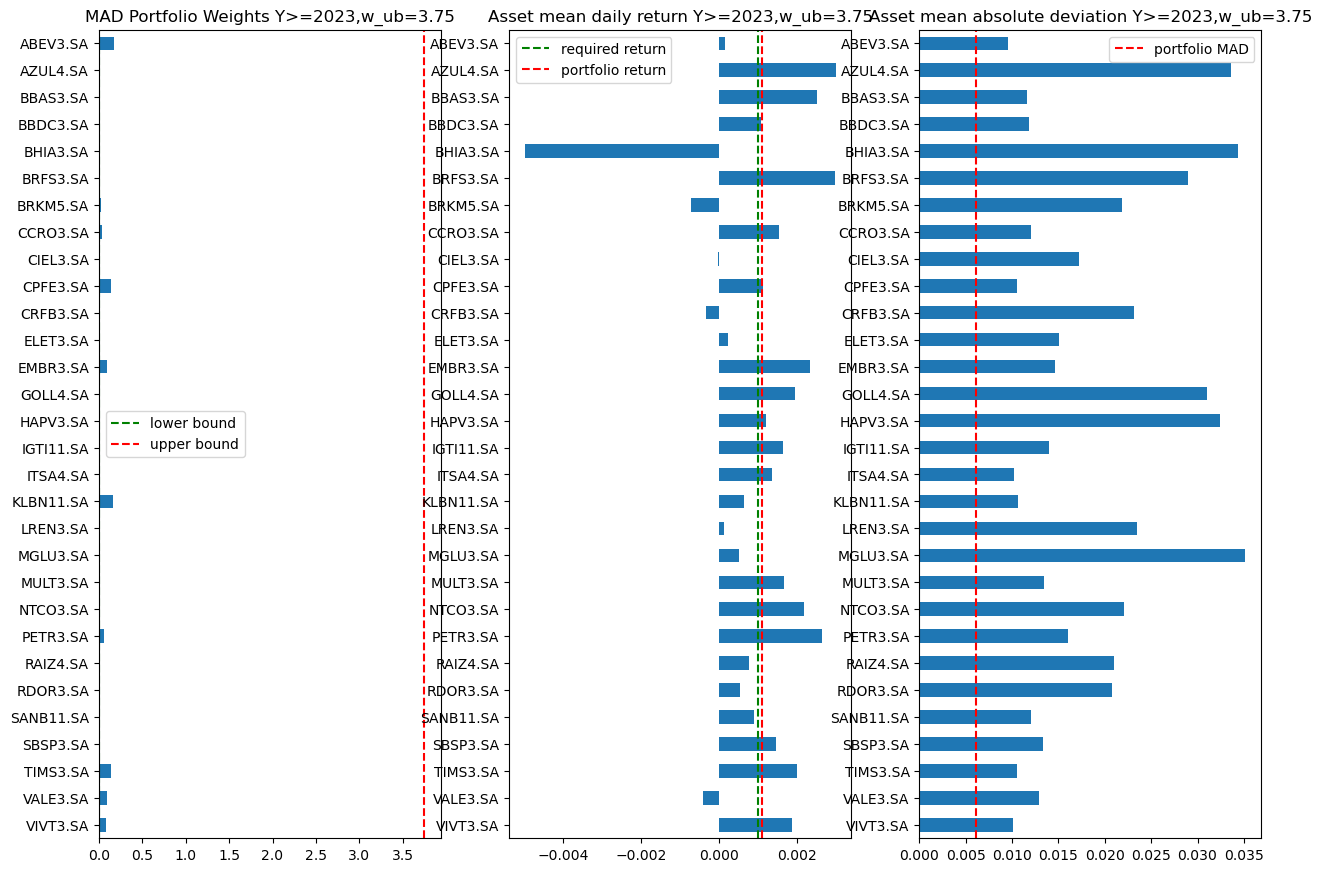

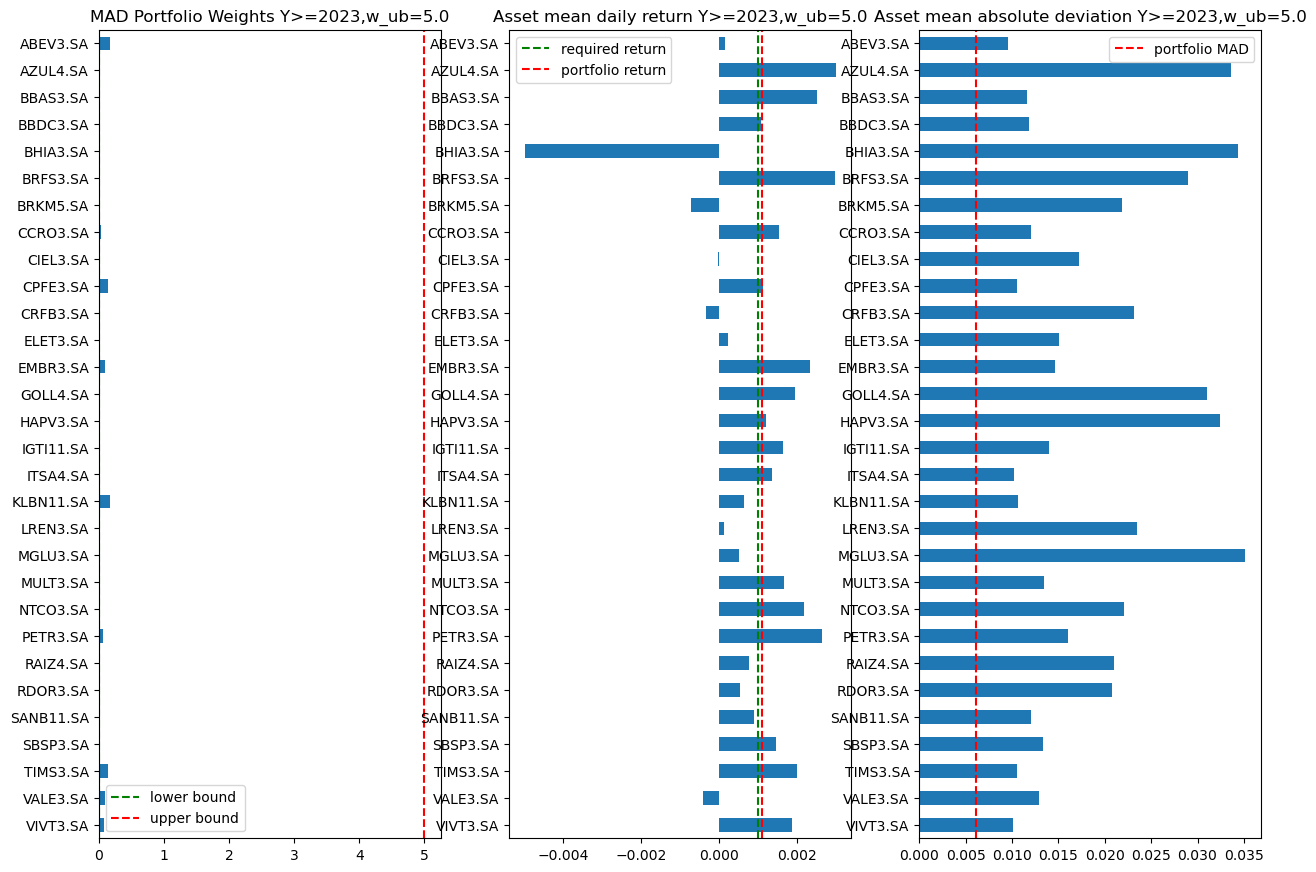

In [257]:
# for each w_ub and last year, slice assets and get the MAD portfolio for each one
for w_ub in w_ub_values:
    print("-" * 60)
    constraint = f"Y>={assets_by_year[-1]},w_ub={w_ub}"
    print(constraint)
    m = mad_portfolio(assets_year)
    m.param["w_lb"] = 0
    m.param["w_ub"] = w_ub
    m.param["R"] = 0.001
    m.option["solver"] = SOLVER
    m.solve()
    mad_visualization(assets_year, m, constraint=constraint)

## Questão 3

Execute os cenários acima sob condições de short selling (nas quais você vende ativos que não possui, contando com uma baixa de preço futura para ganho). Compare os resultados com os obtidos anteriormente.

In [258]:
%%writefile mad_portfolio_short.mod

param R default 0;
param w_lb default 0;
param w_ub default 1;

set ASSETS;
set TIME;

param daily_returns{TIME, ASSETS};
param mean_return{ASSETS};

var w{ASSETS};
var u{TIME} >= 0;
var v{TIME} >= 0;

minimize MAD: sum{t in TIME}(u[t] + v[t]) / card(TIME);

s.t. portfolio_returns {t in TIME}:
    u[t] - v[t] == sum{j in ASSETS}(w[j] * (daily_returns[t, j] - mean_return[j]));

s.t. sum_of_weights: sum{j in ASSETS} w[j] == 1;

s.t. mean_portfolio_return: sum{j in ASSETS}(w[j] * mean_return[j]) >= R;

s.t. diversify {j in ASSETS}: w[j] <= w_ub;

Overwriting mad_portfolio_short.mod


In [259]:
# get the last assets_by_year
assets_year = assets[assets.index.year >= assets_by_year[-1]]

In [260]:
# create a dictionary of values for model_names
model_names = {
    "mad_portfolio.mod": "No short",
    "mad_portfolio_short.mod": "Short",
}

------------------------------------------------------------
Y>=2023,model=No short
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.006055398747
304 simplex iterations
0 barrier iterations
 
Weight lower bound                0.000
Weight upper bound                0.200
Fraction of portfolio invested     1.000
Required portfolio daily return    0.00100
Portfolio mean daily return        0.00111
Portfolio mean absolute deviation  0.00606
------------------------------------------------------------
Y>=2023,model=Short
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.005240256516
346 simplex iterations
0 barrier iterations
 
Weight lower bound                0.000
Weight upper bound                0.200
Fraction of portfolio invested     1.000
Required portfolio daily return    0.00100
Portfolio mean daily return        0.00102
Portfolio mean absolute deviation  0.00524


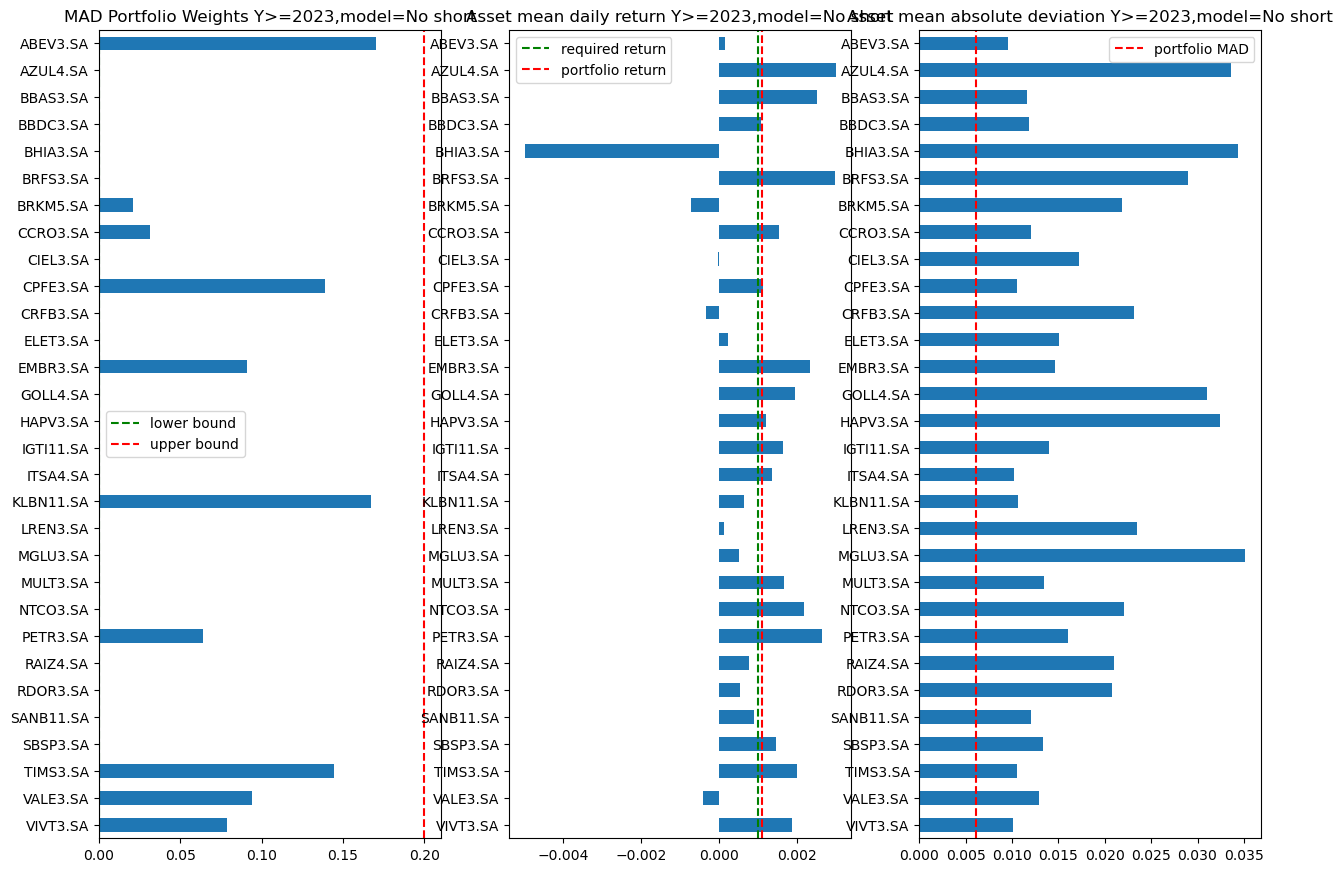

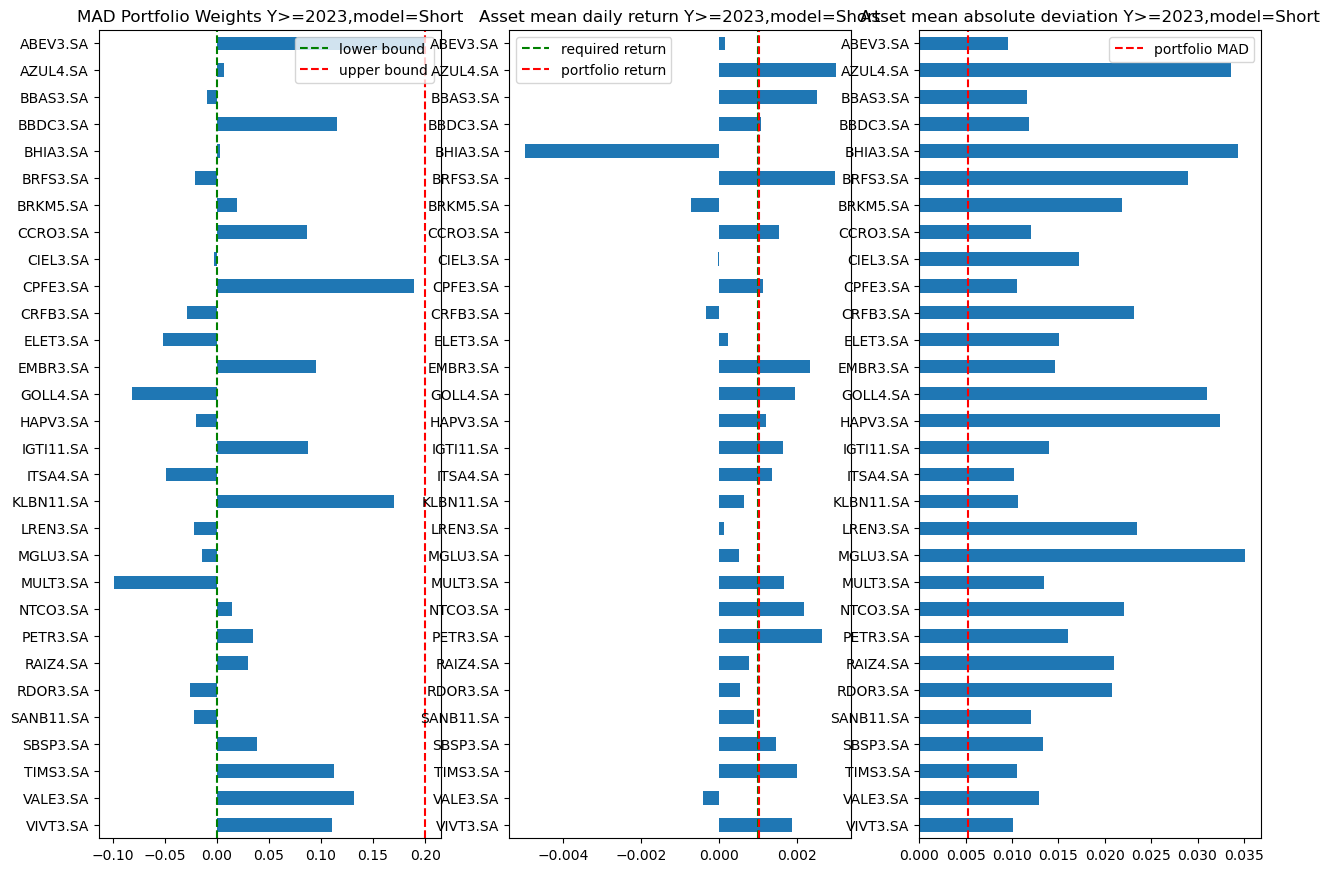

In [261]:
# for each model in model_names and last year, slice assets and get the MAD portfolio for each one
for model_name in model_names:
    print("-" * 60)
    constraint = f"Y>={assets_by_year[-1]},model={model_names[model_name]}"
    print(constraint)
    # acess the model_name key in model_names dictionary
    m = mad_portfolio(assets_year, model_name=model_name)
    m.param["w_lb"] = 0
    m.param["w_ub"] = 0.2
    m.param["R"] = 0.001
    m.option["solver"] = SOLVER
    m.solve()
    mad_visualization(assets_year, m, constraint=constraint)

## Questão 4

A medida de risco usada nos modelos disponibilizados atende pelo nome de Mean-Absolute Deviation (MAD), modifique o código fornecido para usar uma medida de risco alterada em vez da MAD e rode novamente seus experimentos. Faça comparações entre os valores obtidos e reporte diferenças significativas, caso existam.

Esta sessão foi gerada com um misto de conteúdos, mas estou quase certo de que não cheguei a fórmula exata, são eles:

* https://pt.wikipedia.org/wiki/Quantil
* https://statorials.org/pt/quantil/
* https://eprints.lancs.ac.uk/id/eprint/125342/1/Trapero_2018_quantile_forecast_optimal.pdf
* https://core.ac.uk/download/pdf/29140311.pdf

Também usei quantis fixos, imagino que eles devem ser derivados do volume de assets sendo calculados

In [262]:
%%writefile nomad_portfolio.mod

param R default 0;
param w_lb default 0;
param w_ub default 1;
param p_quantile;

set ASSETS;
set TIME;

param daily_returns{TIME, ASSETS};
param mean_return{ASSETS};

var w{ASSETS};
var u{TIME} >= 0;
var v{TIME} >= 0;

minimize MAD: sum{t in TIME}(u[t] + v[t]) / card(TIME);

s.t. portfolio_returns {t in TIME}:
    u[t] - v[t] == sum{j in ASSETS}(w[j] * (daily_returns[t, j] - mean_return[j]));

s.t. sum_of_weights: sum{j in ASSETS} w[j] == 1;

s.t. mean_portfolio_return: sum{j in ASSETS}(w[j] * mean_return[j]) >= R;

s.t. no_short {j in ASSETS}: w[j] >= w_lb;

s.t. diversify {j in ASSETS}: w[j] <= w_ub;

s.t. quantile_portfolio {t in TIME}:
    u[t] - v[t] == sum{j in ASSETS} (w[j] * (daily_returns[t, j] - mean_return[j]));

s.t. quantile_constraint {t in TIME}:
    sum{j in ASSETS} (w[j] * daily_returns[t, j]) >= quantile(p_quantile, {j in ASSETS} w[j] * daily_returns[t, j]);

Overwriting nomad_portfolio.mod


In [263]:
# get the last assets_by_year
assets_year = assets[assets.index.year >= assets_by_year[-1]]

In [264]:
# create a dictionary of values for model_names
model_names = {
    "nomad_portfolio.mod": "Quantile",
}

In [265]:
quantiles = np.linspace(0.01, 0.99, 5)
quantiles

array([0.01 , 0.255, 0.5  , 0.745, 0.99 ])

------------------------------------------------------------
Y>=2023,q=0.01
	nomad_portfolio.mod
	line 34 offset 860
	quantile is not defined
	context:  sum{j in ASSETS} (w[j] * daily_returns[t, j]) >=  >>> quantile( <<< p_quantile, {j in ASSETS} w[j] * daily_returns[t, j]);
	
	Please report any bugs at: https://github.com/ampl/amplpy
	
	For support/feedback go to https://discuss.ampl.com or e-mail <support@ampl.com>
	
HiGHS 1.6.0:HiGHS 1.6.0: optimal solution; objective 0.006055398747
304 simplex iterations
0 barrier iterations
 
Weight lower bound                0.000
Weight upper bound                0.200
Fraction of portfolio invested     1.000
Required portfolio daily return    0.00100
Portfolio mean daily return        0.00111
Portfolio mean absolute deviation  0.00606
------------------------------------------------------------
Y>=2023,q=0.255
	nomad_portfolio.mod
	line 34 offset 860
	quantile is not defined
	context:  sum{j in ASSETS} (w[j] * daily_returns[t, j]) >=  >>> quant

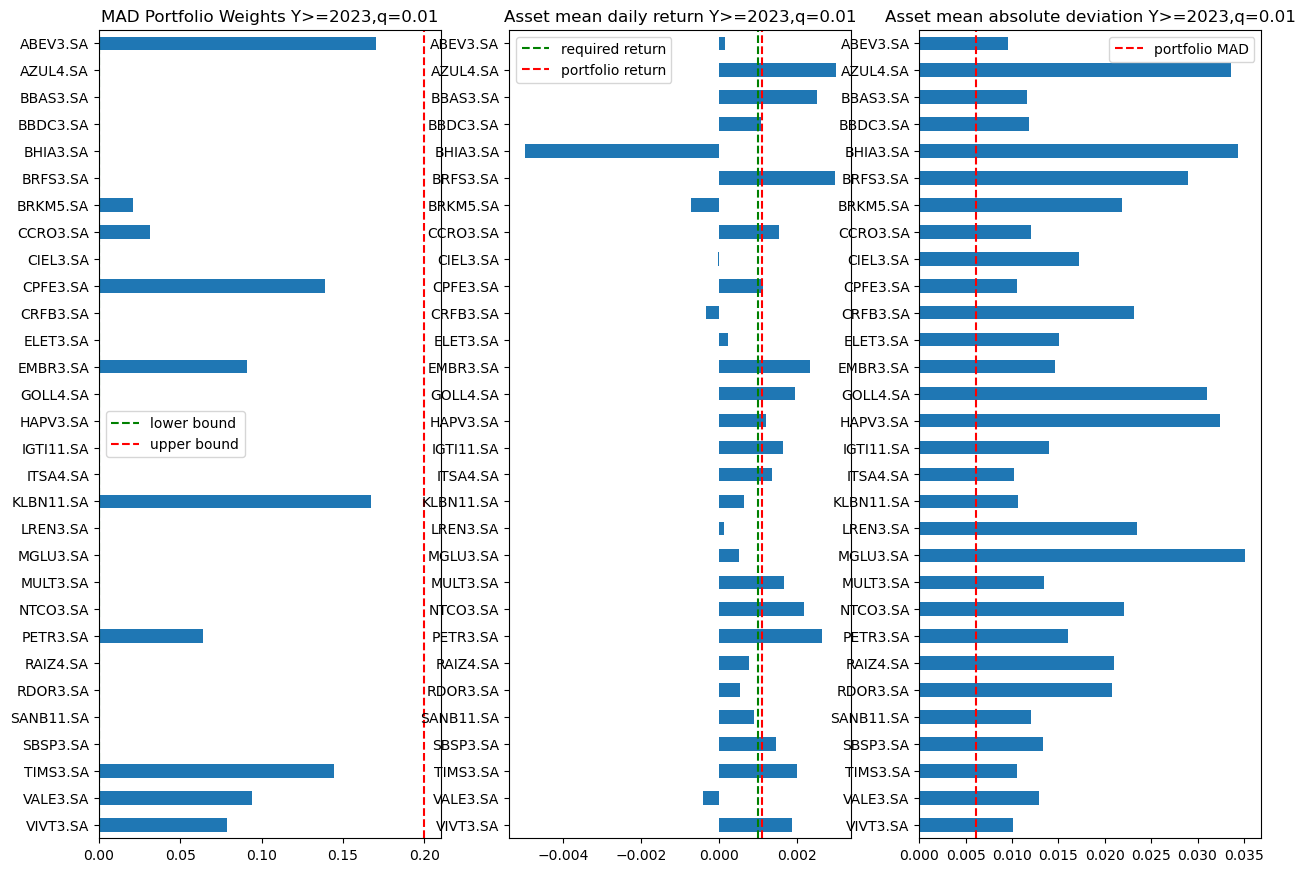

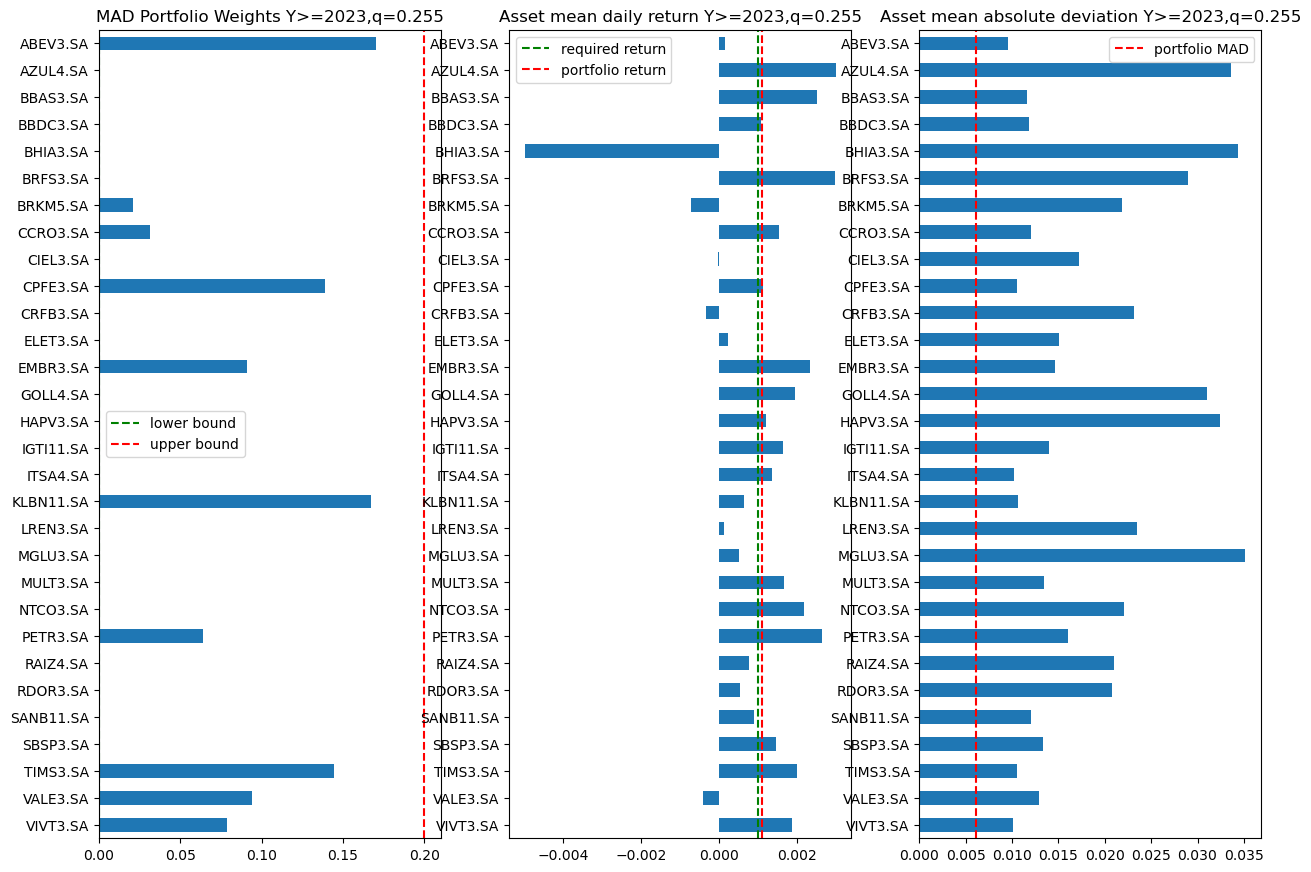

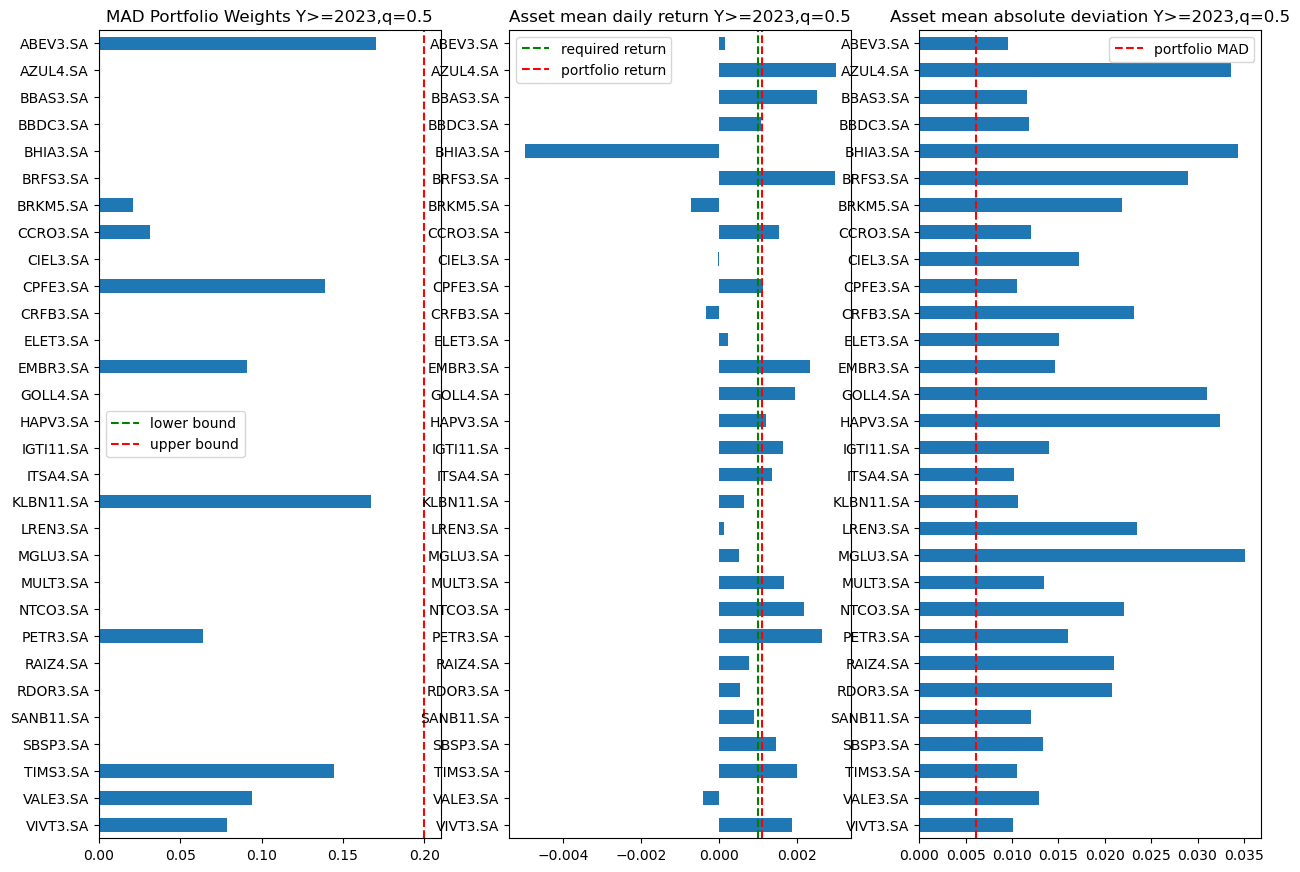

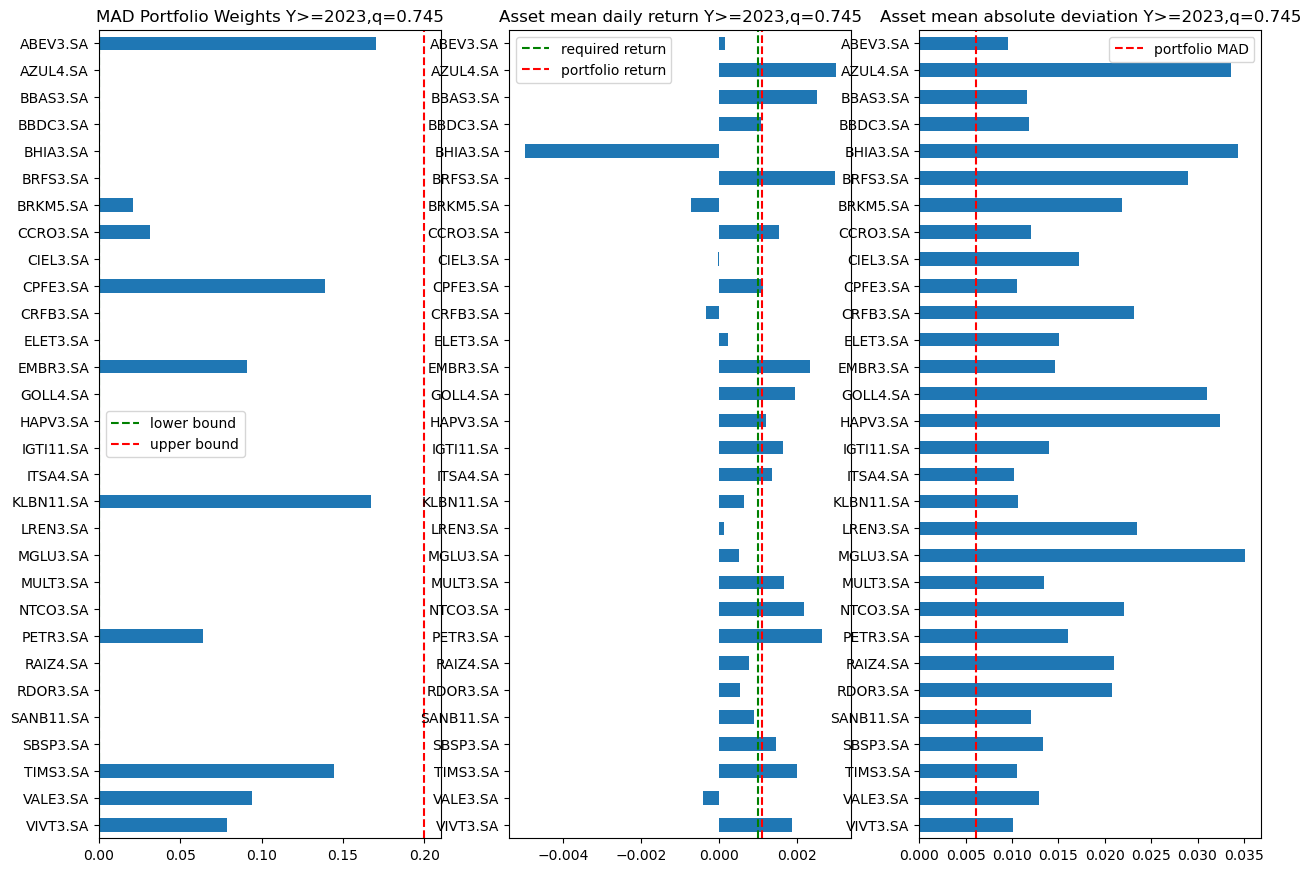

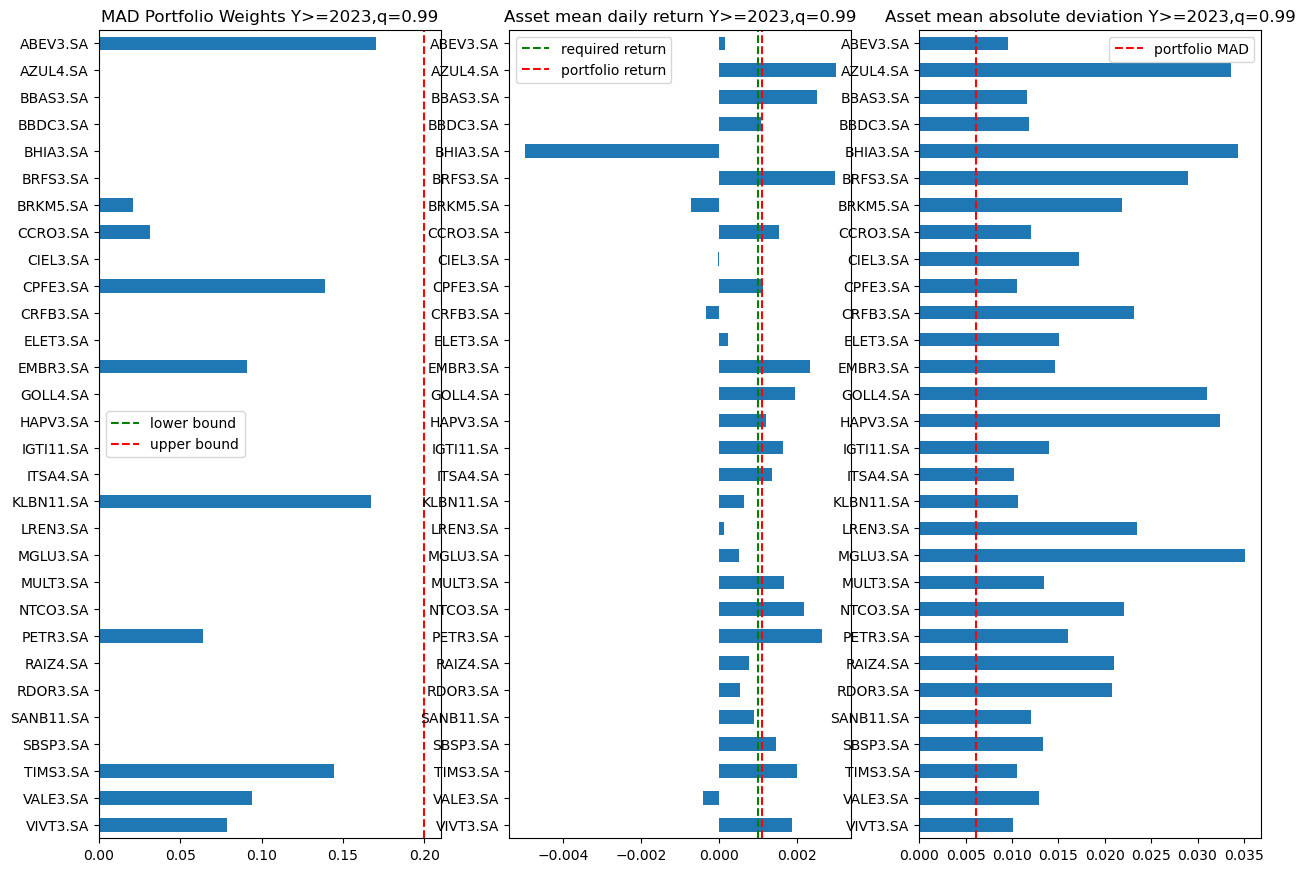

In [266]:
# for each model in model_names and last year, slice assets and get the MAD portfolio for each one
for model_name in model_names:
    for q in quantiles:
        print("-" * 60)
        constraint = f"Y>={assets_by_year[-1]},q={q}"
        print(constraint)
        m = mad_portfolio(assets_year, model_name=model_name)
        m.param["w_lb"] = 0
        m.param["w_ub"] = 0.2
        m.param["R"] = 0.001
        m.param["p_quantile"] = q
        m.option["solver"] = SOLVER
        m.solve()
        mad_visualization(assets_year, m, constraint=constraint)